# 2D Random Walker

The Random Walk on a 2D surface with periodic boundary conditions along one direction is explored in this work. 

- We first simulate the many random walks for $\textbf{nSteps}$ for fixed dimension of $X,Y$. 

- Then we trace out the Y-values and try to find the distribution of the random variable x by generating a list of all X-values across runs. 

- This yields the possible probability ditribution. 

The Following are the parameters that are involved for this study:
- $nSteps$: No. of steps the walker takes in each walk
- $nRuns$: No.of Random Walks of nSteps over which we average
- $(X,Y)$ : The Boundary conditions for the cylindrical surface
- $P(x)$ : Probability of finding the particle x that we find after tracing values of y


In [1]:
import numpy as np
import random
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import collections
import pandas as pd
import scipy.interpolate
import scipy.stats
import csv

def takeStep(extraChoices=[]):
    stepChoices = [[1,0],[-1,0],[0,1],[0,-1]]
    return random.choice(stepChoices)


def normalMove(Loc,bcX,bcY):
    newLoc = [bcX+1,bcY+1]
    while abs(newLoc[0])> bcX or abs(newLoc[1])> bcY:
        step = takeStep()
        newLoc = [Loc[0]+step[0],Loc[1]+step[1]]
    return newLoc,step


def periodicMove(Loc,bcX,bcY):
    newLoc = [bcX+1,bcY+1]
    while abs(newLoc[0])> bcX :
        step = takeStep()
        newLoc = [Loc[0]+step[0],Loc[1]+step[1]]   
        if abs(newLoc[1])== bcY+1:
            y = newLoc[1]
            newLoc[1] = -1*(abs(y)-1)* int(y/abs(y))        
    return newLoc,step

def Walk(nSteps,bcX,bcY):
    pathChoices = []
    path = []
    startLoc = [0,0]
    Loc = startLoc
    for i in range(nSteps):
        Loc,step = periodicMove(Loc,bcX,bcY)
        path.append(Loc)
        pathChoices.append(step)
    return tuple(Loc)

def dict_to_csv(dictionary,title,xhead='',yhead=''):
        with open(title+'.csv', 'w') as f:
                f.write(xhead+'\t'+yhead+'\n')
                [f.write('{0}\t{1}\n'.format(key, value)) for key, value in dictionary.items()]

def runExperiment(nSteps,runs,bcX,bcY):
    distribution = []
    for run in range(runs):
        distribution.append(Walk(nSteps,bcX,bcY))
    #print(distribution)    
    collectPaths = dict(collections.Counter(distribution))
    title = 'nSteps'+str(nSteps)+'_runs'+str(runs)+'_X'+str(bcX)+'_Y'+str(bcY)
    dict_to_csv(collectPaths,title,xhead = '(x,y)',yhead='P[(x,y)]')
    
    return distribution

def alongAxes(distribution,Y):
    distX = [x[0] for x in distribution  if x[1]==Y ]
    collectPaths = dict(collections.Counter(distX))
    probabilityDistribution = {k: v /len(distribution)
                               for k, v in collectPaths.items()}
    return distX,probabilityDistribution
    
def traceY(distribution,title):
    distX = [x[0] for x in distribution]
    collectPaths = dict(collections.Counter(distX))
    probabilityDistribution = {k: v /(total) 
                               for total in (sum(collectPaths.values()),) 
                               for k, v in collectPaths.items()}
    dict_to_csv(probabilityDistribution ,title+'_tracedY',xhead = 'x',yhead='P(x) traced over Y')
    return distX,probabilityDistribution


    
def plotDistribution(probabilityDistribution,title='',textstr='', limits=False, xlim= (), ylim=() ):
    x, y = zip(*sorted(probabilityDistribution.items())) # unpack a list of pairs into two tuples
    figs, axs = plt.subplots()
    axs.scatter(x,y)
    axs.set_xlabel('x',fontsize=16)
    axs.set_ylabel('P(x)',fontsize=16)
    if limits==True:
        axs.set_xlim(xlim[0],xlim[1])
        axs.set_ylim(ylim[0],ylim[1])
    plt.title(title)
    plt.gcf().text(0.0, -0.1, textstr, fontsize=14)
    #plt.savefig(title+'.png',dpi=200)
    plt.show()  
    return(x,y)

def nonGaussianParameter(distribution):
    second_moment = scipy.stats.moment(distribution, moment =2)
    fourth_moment = scipy.stats.moment(distribution, moment =4)
    nGP = (3* fourth_moment)/(5* (second_moment)**2) - 1
    return nGP
    
    

def testDist(x,y,distribution):
    #f = scipy.interpolate.interp1d(x,y)
    #a = np.linspace(-25,25,1000)  
    #print(scipy.stats.kstest(f(a),'norm',N=100))
    #plt.plot(a,f(a))
    var = np.var(distribution)
    std = np.std(distribution)
    ngp = nonGaussianParameter(distribution)
    print('Non-Gaussian Parameter:', ngp)
    print('Variance:',var)
    print('Standard Deviation:',std)
    return(std,var,ngp)

def calculation(nSteps,runs,bcX,bcY):    
    title = ('nSteps'+str(nSteps) +'_runs'+str(runs) 
             +'_X'+str(bcX)+'_Y'+str(bcY))
    textstr = ('nSteps:'+str(nSteps) 
               + '\n'+'_runs:' +str(runs)
               + '\n'+'bcX:'+str(bcX)+'  bcY:'+str(bcY))
    distribution = runExperiment(nSteps,runs,bcX,bcY)

    #The probability dsitribution P(x) by tracing out Y values
    traceDistX, traceProbDistX = traceY(distribution,title)
    x,y  = plotDistribution(traceProbDistX, title +'_traced')
    std,var,ngp  = testDist(x,y,traceDistX)
    
    #The untraced distribution P(X) along Y=0
    alongAxesDistZ, alongAxesProbDistZ = alongAxes(distribution,0)
    Xz, Yz = plotDistribution(alongAxesProbDistZ, title+'_alongYz')
    stdZ,varZ,ngpZ = testDist(Xz, Yz,alongAxesDistZ )
    dict_to_csv(alongAxesProbDistZ ,title+'_alongYz',xhead = 'x',yhead='P(x)_alongYz')
    
    if bcY>0:
        #The untraced distribution P(X) along Y=1
        alongAxesDistU1, alongAxesProbDistU1 = alongAxes(distribution,1) 
        Xu1,Yu1  = plotDistribution(alongAxesProbDistU1, title+'_alongYu1')
        stdU1,varU1,ngpU1 = testDist(Xu1,Yu1,alongAxesDistU1)
        dict_to_csv(alongAxesProbDistU1,title+'_alongYu1',xhead = 'x',yhead='P(x)_alongYu1')
    
        #The untraced distribution P(X) along Y=-1
        alongAxesDistD1, alongAxesProbDistD1 = alongAxes(distribution,-1)
        Xd1,Yd1  = plotDistribution(alongAxesProbDistD1, title+'_alongYd1')
        stdD1,varD1,ngpD1 = testDist(Xd1,Yd1,alongAxesDistD1)
        dict_to_csv(alongAxesProbDistD1,title+'_alongYd1',xhead = 'x',yhead='P(x)_alongYd1')

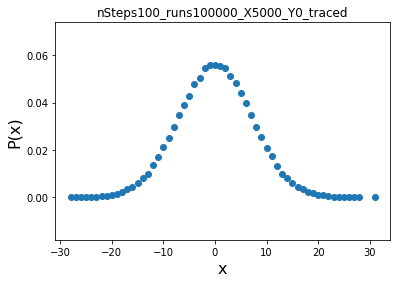

Non-Gaussian Parameter: 0.7719586927212547
Variance: 50.02922388760001
Standard Deviation: 7.07313395091596


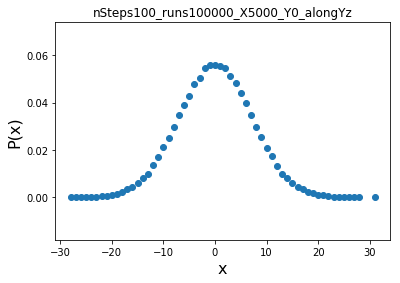

Non-Gaussian Parameter: 0.7719586927212547
Variance: 50.02922388760001
Standard Deviation: 7.07313395091596


In [2]:
calculation(100,100000,5000,0)

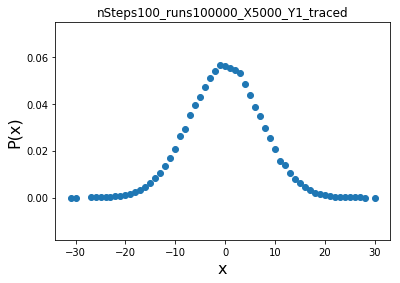

Non-Gaussian Parameter: 0.7909831080674676
Variance: 50.1449126076
Standard Deviation: 7.0813072668540515


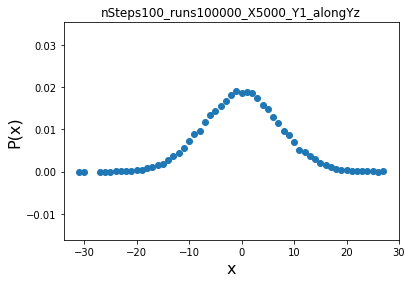

Non-Gaussian Parameter: 0.7764501708846268
Variance: 49.90613275283125
Standard Deviation: 7.064427277057302


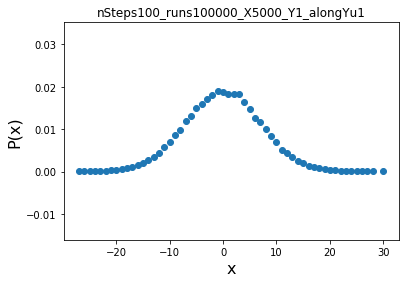

Non-Gaussian Parameter: 0.8344235809104905
Variance: 50.42067823310714
Standard Deviation: 7.100751948428218


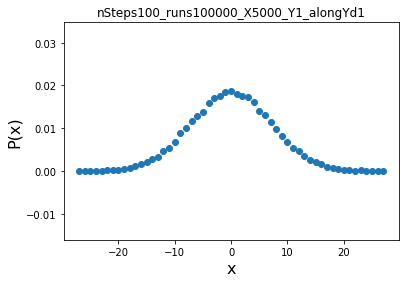

Non-Gaussian Parameter: 0.7604831586837242
Variance: 50.10489363918207
Standard Deviation: 7.0784810262641855


In [3]:
calculation(100,100000,5000,1)

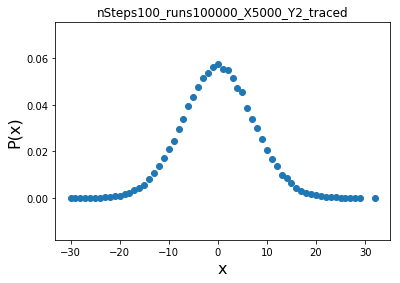

Non-Gaussian Parameter: 0.7867311206620013
Variance: 49.850875647100004
Standard Deviation: 7.0605152536553595


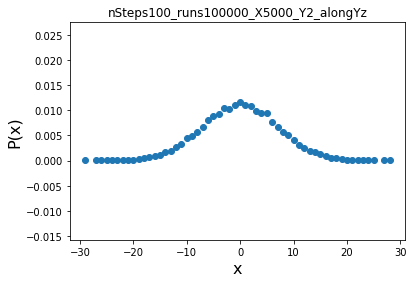

Non-Gaussian Parameter: 0.7923392001934253
Variance: 50.19597969337803
Standard Deviation: 7.084912116136517


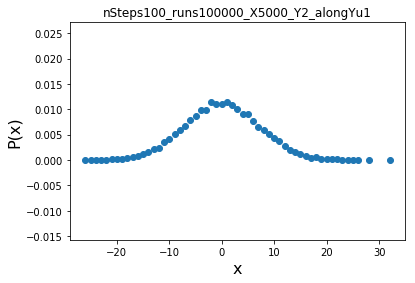

Non-Gaussian Parameter: 0.7892823600601606
Variance: 49.987139446765966
Standard Deviation: 7.0701583749422445


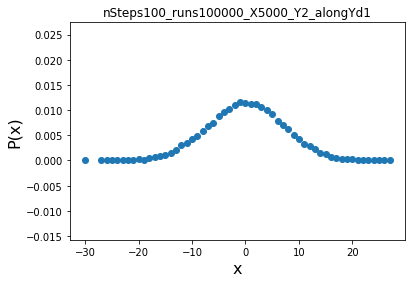

Non-Gaussian Parameter: 0.7803587625898583
Variance: 49.66730090659854
Standard Deviation: 7.047503168257432


In [4]:
calculation(100,100000,5000,2)

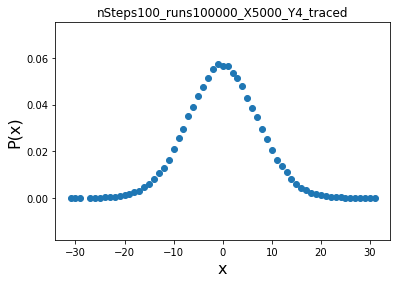

Non-Gaussian Parameter: 0.8084141257036224
Variance: 50.1797021916
Standard Deviation: 7.083763278907617


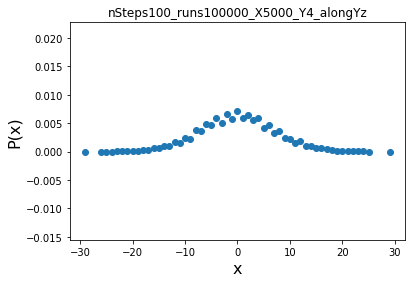

Non-Gaussian Parameter: 0.8289873129181828
Variance: 50.19782165392469
Standard Deviation: 7.085042106715012


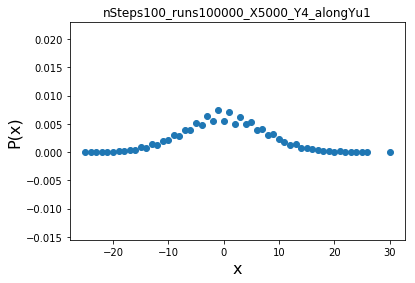

Non-Gaussian Parameter: 0.8027948822800852
Variance: 48.7938305940796
Standard Deviation: 6.985258090727901


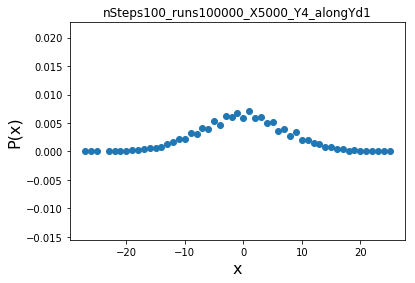

Non-Gaussian Parameter: 0.7872366973951459
Variance: 49.68178249273601
Standard Deviation: 7.048530520096796


In [5]:
calculation(100,100000,5000,4)

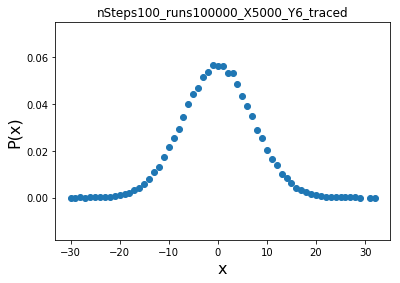

Non-Gaussian Parameter: 0.805367849201279
Variance: 50.18925439750001
Standard Deviation: 7.084437479256911


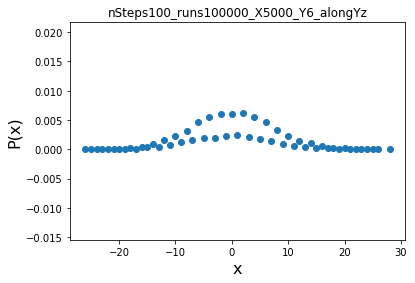

Non-Gaussian Parameter: 0.8166586053535281
Variance: 50.561731673937444
Standard Deviation: 7.110677300647066


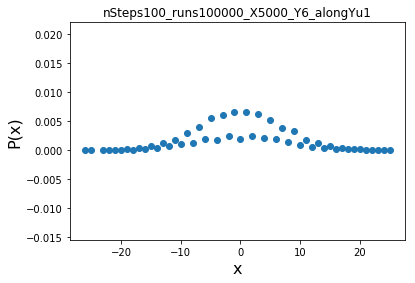

Non-Gaussian Parameter: 0.7945793170882622
Variance: 49.64420860201415
Standard Deviation: 7.045864645450845


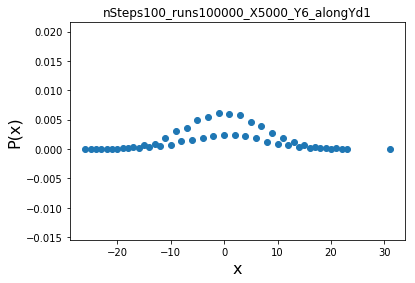

Non-Gaussian Parameter: 0.8134606608321808
Variance: 50.30653291071681
Standard Deviation: 7.092709842557837


In [6]:
calculation(100,100000,5000,6)

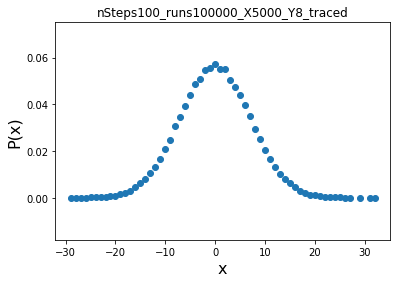

Non-Gaussian Parameter: 0.8027105283366709
Variance: 50.0690006599
Standard Deviation: 7.075945213178237


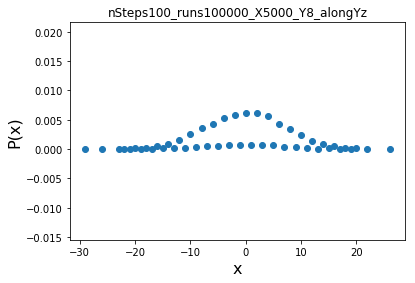

Non-Gaussian Parameter: 0.7529186412692643
Variance: 50.17715334165258
Standard Deviation: 7.083583368723247


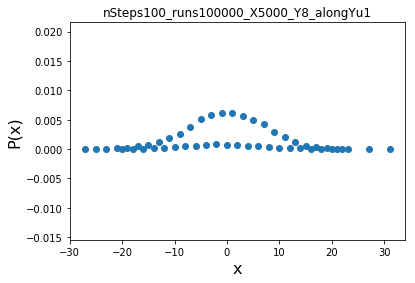

Non-Gaussian Parameter: 0.8072799380776319
Variance: 50.10771870939686
Standard Deviation: 7.078680576872844


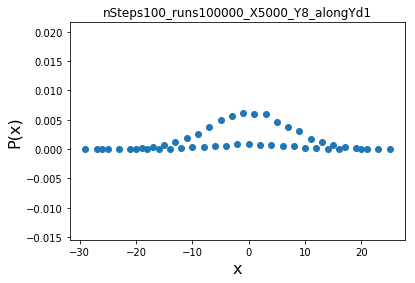

Non-Gaussian Parameter: 0.8405384723001263
Variance: 51.177564388595314
Standard Deviation: 7.153849620211157


In [7]:
calculation(100,100000,5000,8)

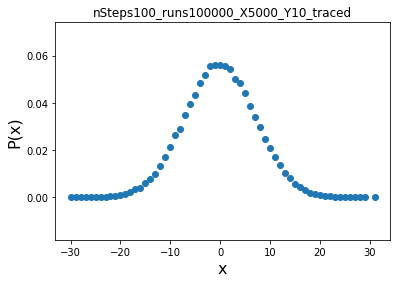

Non-Gaussian Parameter: 0.7910846076444735
Variance: 49.844663497499994
Standard Deviation: 7.060075318118072


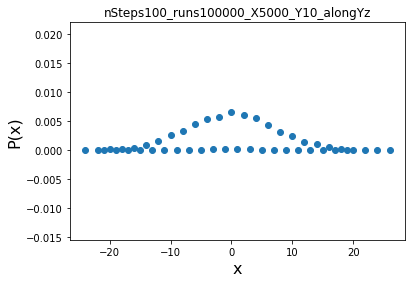

Non-Gaussian Parameter: 0.7355539117990402
Variance: 49.11676747411386
Standard Deviation: 7.008335570883707


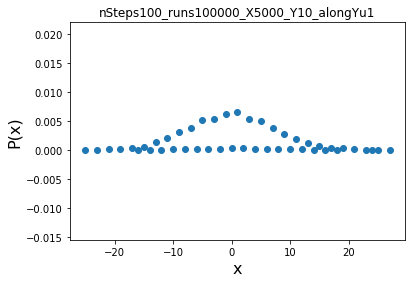

Non-Gaussian Parameter: 0.8002813988746187
Variance: 51.11547026208197
Standard Deviation: 7.149508393035284


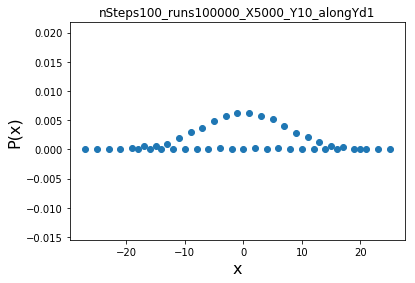

Non-Gaussian Parameter: 0.7831379650445995
Variance: 50.16505651003925
Standard Deviation: 7.082729453398545


In [22]:
calculation(100,100000,5000,10)

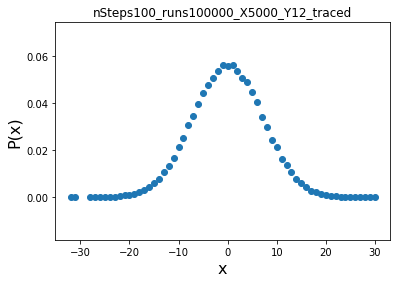

Non-Gaussian Parameter: 0.8010664153855438
Variance: 50.1576638879
Standard Deviation: 7.082207557527526


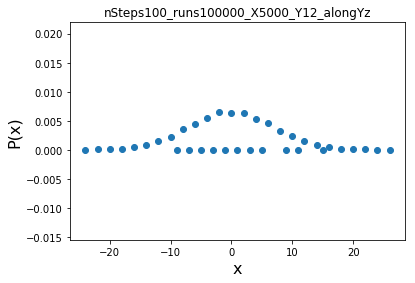

Non-Gaussian Parameter: 0.8061191772433731
Variance: 49.615974222834424
Standard Deviation: 7.043860746979203


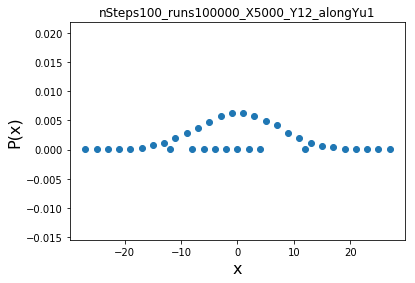

Non-Gaussian Parameter: 0.8292838172444492
Variance: 50.687030562980446
Standard Deviation: 7.119482464546173


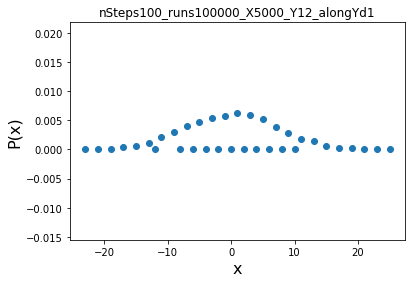

Non-Gaussian Parameter: 0.6942428440628288
Variance: 50.1327584866763
Standard Deviation: 7.080449031429878


In [8]:
calculation(100,100000,5000,12)

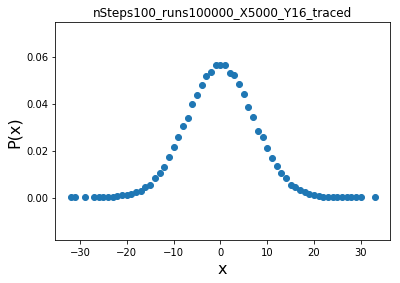

Non-Gaussian Parameter: 0.7889660275470982
Variance: 50.076300703600005
Standard Deviation: 7.076461029610776


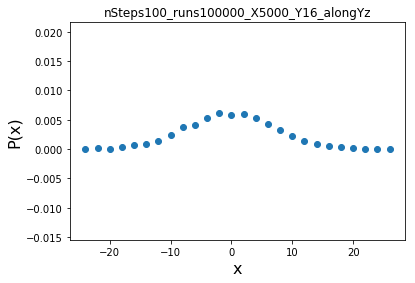

Non-Gaussian Parameter: 0.7922762779922252
Variance: 51.60802519276034
Standard Deviation: 7.183872576317062


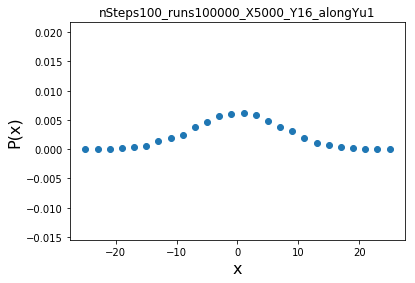

Non-Gaussian Parameter: 0.760352210093832
Variance: 50.94972891734531
Standard Deviation: 7.137907880979224


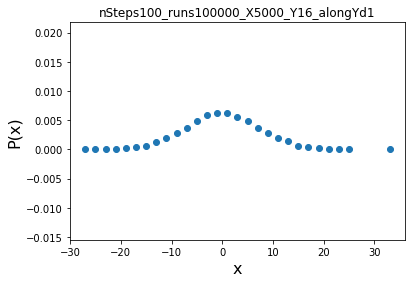

Non-Gaussian Parameter: 0.8525299079304152
Variance: 50.60280946834654
Standard Deviation: 7.113565172847336


In [9]:
calculation(100,100000,5000,16)

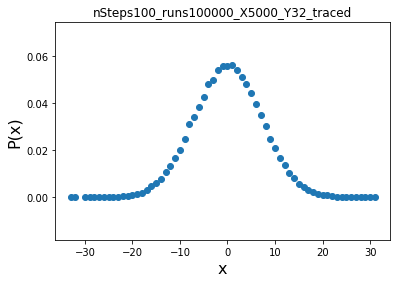

Non-Gaussian Parameter: 0.7940631695160267
Variance: 50.3365247356
Standard Deviation: 7.094823798770481


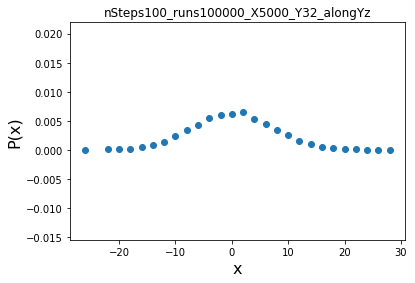

Non-Gaussian Parameter: 0.7907266142479834
Variance: 49.72120287932946
Standard Deviation: 7.0513263205817855


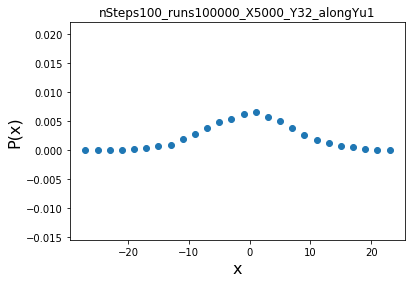

Non-Gaussian Parameter: 0.8267657203232404
Variance: 50.914709630073446
Standard Deviation: 7.135454409501433


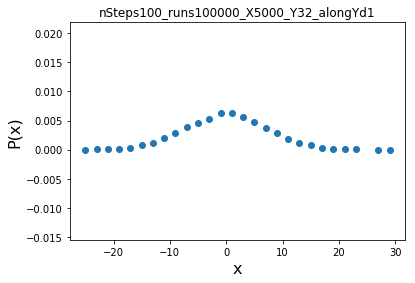

Non-Gaussian Parameter: 0.7727140998191209
Variance: 50.42718715144838
Standard Deviation: 7.10121025962817


In [10]:
calculation(100,100000,5000,32)

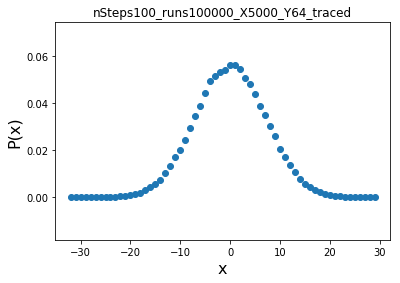

Non-Gaussian Parameter: 0.7990211233452715
Variance: 50.3104654716
Standard Deviation: 7.092987062697915


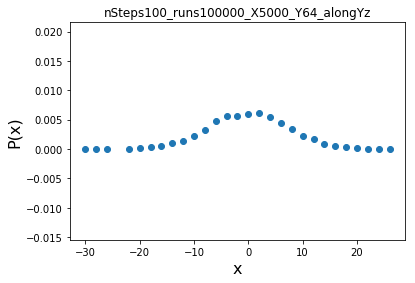

Non-Gaussian Parameter: 0.793572976790172
Variance: 52.309865648464495
Standard Deviation: 7.232555955432664


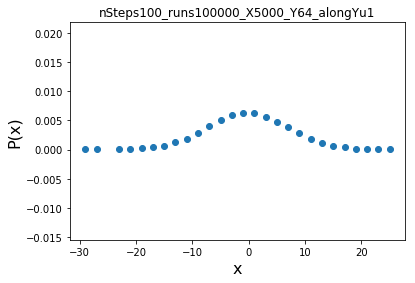

Non-Gaussian Parameter: 0.848589234213692
Variance: 50.47924091339289
Standard Deviation: 7.104874447405309


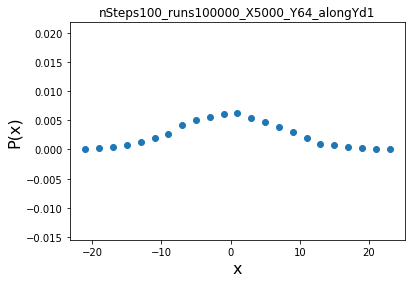

Non-Gaussian Parameter: 0.7268195051312176
Variance: 51.78857859610363
Standard Deviation: 7.196428183210309


In [11]:
calculation(100,100000,5000,64)

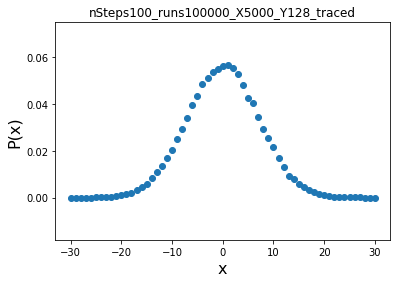

Non-Gaussian Parameter: 0.7959701818682094
Variance: 50.07730789749999
Standard Deviation: 7.076532194337845


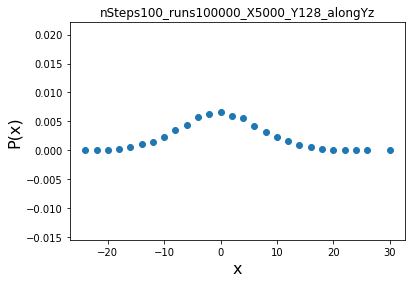

Non-Gaussian Parameter: 0.8579890455815129
Variance: 49.946848634274616
Standard Deviation: 7.067308443408609


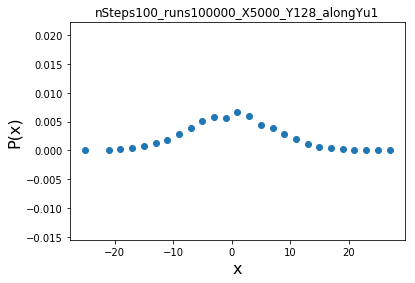

Non-Gaussian Parameter: 0.754398503163376
Variance: 50.46905398565651
Standard Deviation: 7.104157514136107


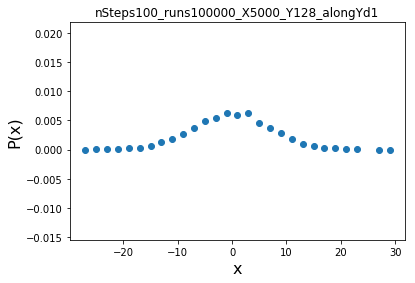

Non-Gaussian Parameter: 0.8393096997836584
Variance: 49.42438317799879
Standard Deviation: 7.030247732334813


In [12]:
calculation(100,100000,5000,128)

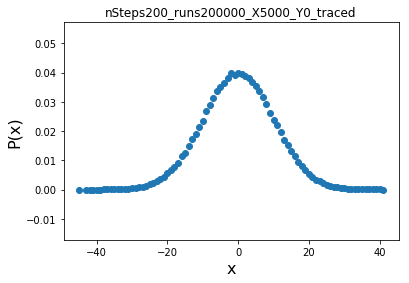

Non-Gaussian Parameter: 0.7928193932446916
Variance: 99.77390650309998
Standard Deviation: 9.988688928137666


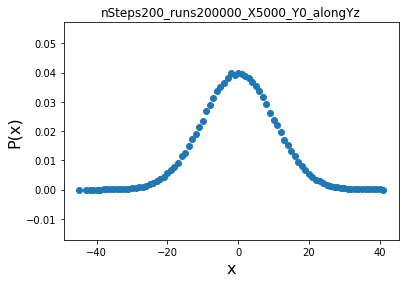

Non-Gaussian Parameter: 0.7928193932446916
Variance: 99.77390650309998
Standard Deviation: 9.988688928137666


In [13]:
calculation(200,200000,5000,0)

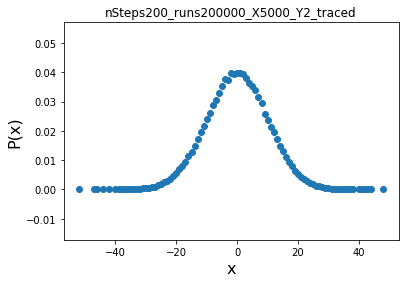

Non-Gaussian Parameter: 0.7989299368725913
Variance: 100.43007693749999
Standard Deviation: 10.02148077568879


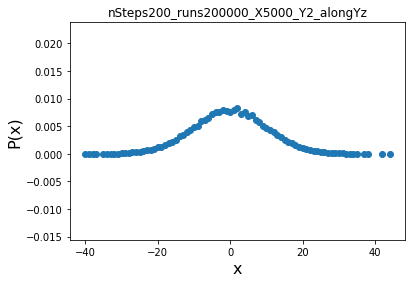

Non-Gaussian Parameter: 0.7990572766779112
Variance: 100.92183051834908
Standard Deviation: 10.04598579126753


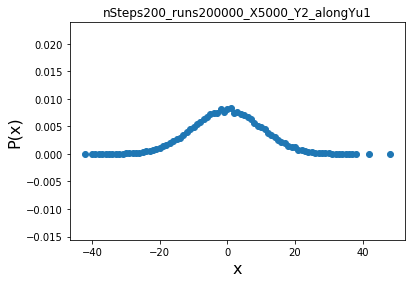

Non-Gaussian Parameter: 0.7884909474011277
Variance: 99.2581551249424
Standard Deviation: 9.962838708166585


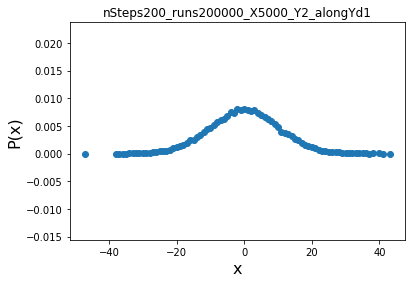

Non-Gaussian Parameter: 0.8094838919454421
Variance: 100.90939505709375
Standard Deviation: 10.045366845321963


In [14]:
calculation(200,200000,5000,2)

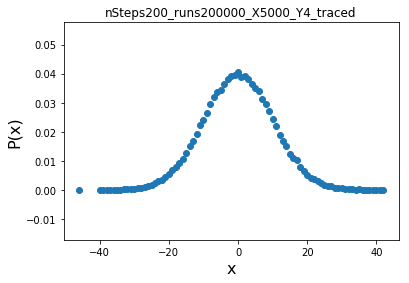

Non-Gaussian Parameter: 0.7968483387573344
Variance: 100.04618259360001
Standard Deviation: 10.002308863137552


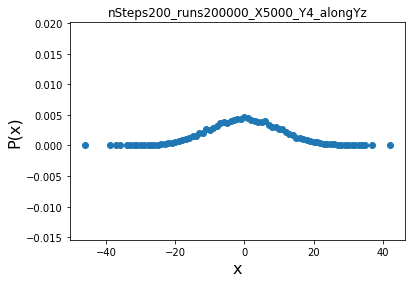

Non-Gaussian Parameter: 0.7828231441291196
Variance: 99.39667759379802
Standard Deviation: 9.969788242174355


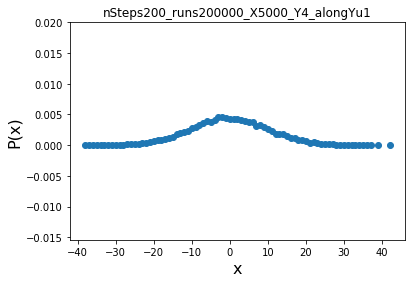

Non-Gaussian Parameter: 0.818319687075282
Variance: 101.67402485329426
Standard Deviation: 10.083353849453776


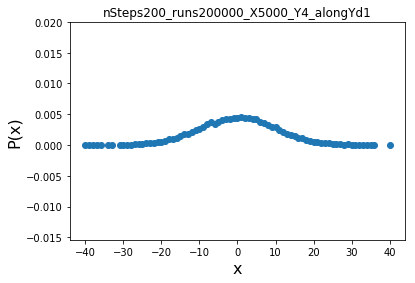

Non-Gaussian Parameter: 0.8207515302947321
Variance: 97.55343723246928
Standard Deviation: 9.876914357858393


In [15]:
calculation(200,200000,5000,4)

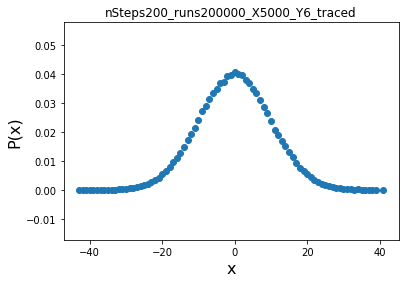

Non-Gaussian Parameter: 0.7971972264035072
Variance: 99.70563104639997
Standard Deviation: 9.985270704713017


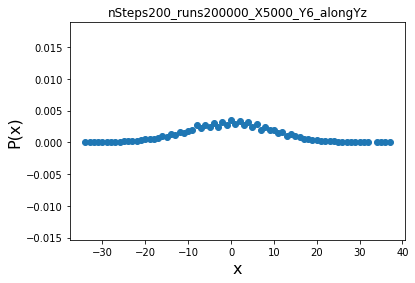

Non-Gaussian Parameter: 0.7976756503801805
Variance: 97.84408504512089
Standard Deviation: 9.89161690751926


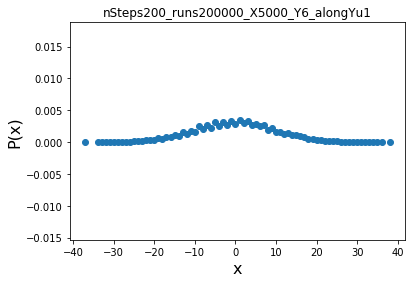

Non-Gaussian Parameter: 0.7876772352443981
Variance: 98.74992047447977
Standard Deviation: 9.937299455811914


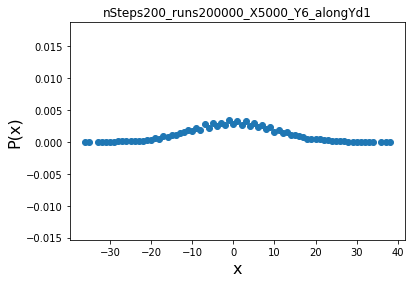

Non-Gaussian Parameter: 0.7937127181492163
Variance: 102.3326836944883
Standard Deviation: 10.115961827453102


In [23]:
calculation(200,200000,5000,6)

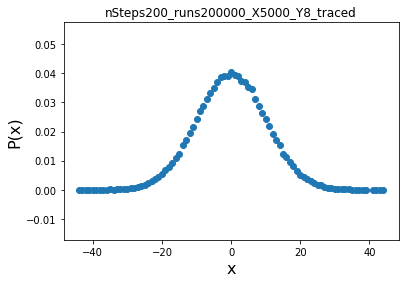

Non-Gaussian Parameter: 0.7948426592397548
Variance: 99.85573930497502
Standard Deviation: 9.992784361977147


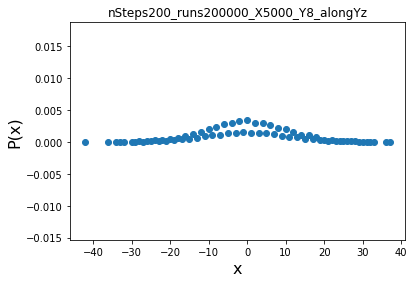

Non-Gaussian Parameter: 0.7725863474344075
Variance: 100.21700215920066
Standard Deviation: 10.010844228095884


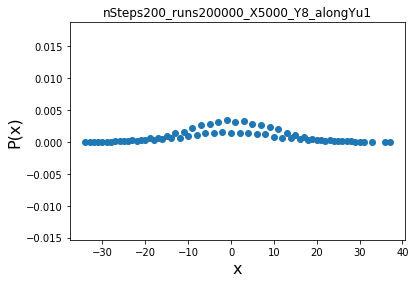

Non-Gaussian Parameter: 0.7795658266870762
Variance: 97.53411108407796
Standard Deviation: 9.875935959901621


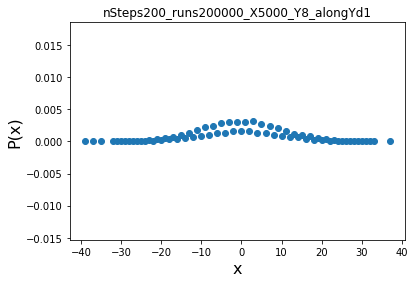

Non-Gaussian Parameter: 0.7725494197330001
Variance: 99.44571841303272
Standard Deviation: 9.972247410339994


In [16]:
calculation(200,200000,5000,8)

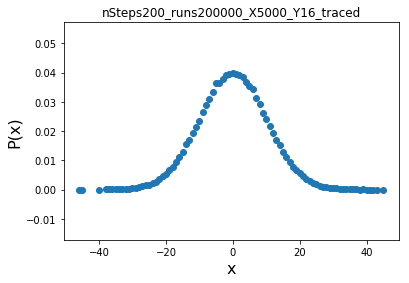

Non-Gaussian Parameter: 0.7986199645219612
Variance: 100.08706069097502
Standard Deviation: 10.004352087515464


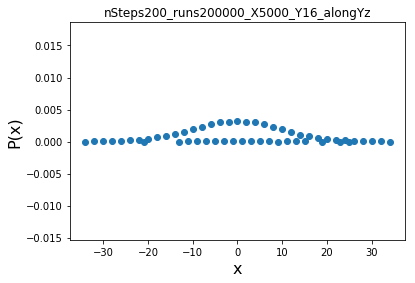

Non-Gaussian Parameter: 0.7662689909380687
Variance: 97.05498080728997
Standard Deviation: 9.851648633974415


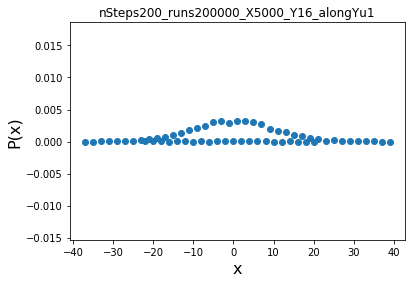

Non-Gaussian Parameter: 0.8335355464632279
Variance: 99.82976754803268
Standard Deviation: 9.991484751929148


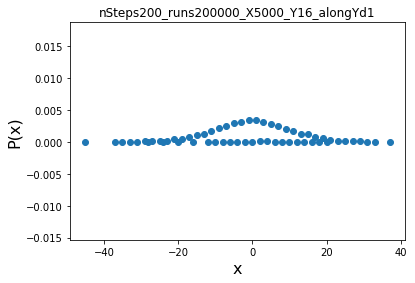

Non-Gaussian Parameter: 0.8382347875305891
Variance: 97.07920489320173
Standard Deviation: 9.85287800052359


In [17]:
calculation(200,200000,5000,16)

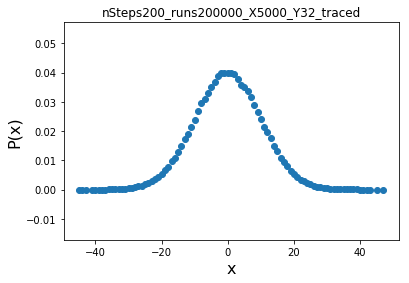

Non-Gaussian Parameter: 0.8034926231098378
Variance: 99.6853198319
Standard Deviation: 9.98425359413011


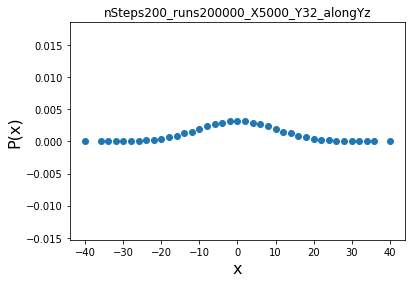

Non-Gaussian Parameter: 0.8332263091235437
Variance: 98.24816216042238
Standard Deviation: 9.912021093622752


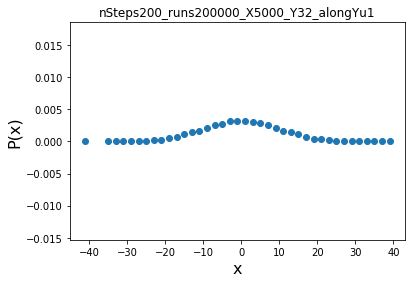

Non-Gaussian Parameter: 0.8005500340545042
Variance: 97.07226839746923
Standard Deviation: 9.852525990702548


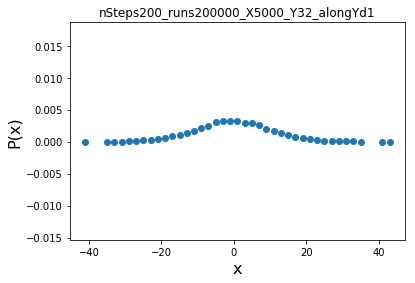

Non-Gaussian Parameter: 0.8666240593909096
Variance: 100.55386363283544
Standard Deviation: 10.027654941851333


In [18]:
calculation(200,200000,5000,32)

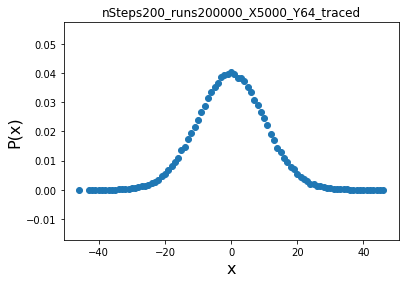

Non-Gaussian Parameter: 0.8118406984038791
Variance: 100.20486899999999
Standard Deviation: 10.01023820895387


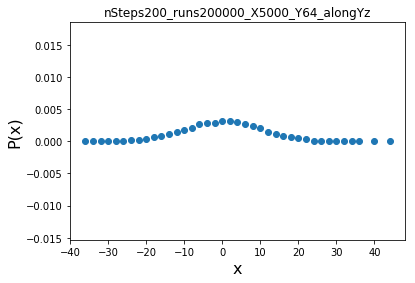

Non-Gaussian Parameter: 0.8802282498572518
Variance: 100.7343657173672
Standard Deviation: 10.036651120636165


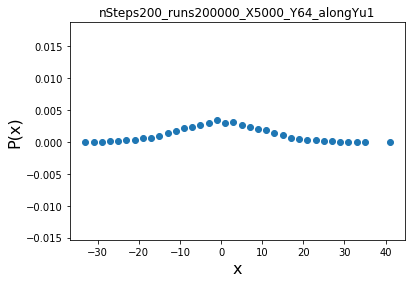

Non-Gaussian Parameter: 0.7784445895276122
Variance: 100.21299011167712
Standard Deviation: 10.010643841016277


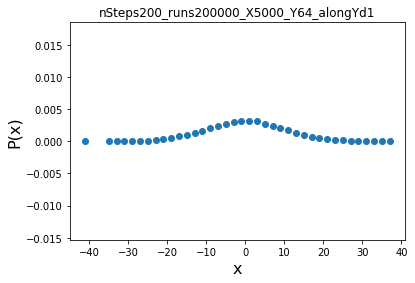

Non-Gaussian Parameter: 0.828300093908424
Variance: 101.83503314550067
Standard Deviation: 10.091334557208015


In [19]:
calculation(200,200000,5000,64)

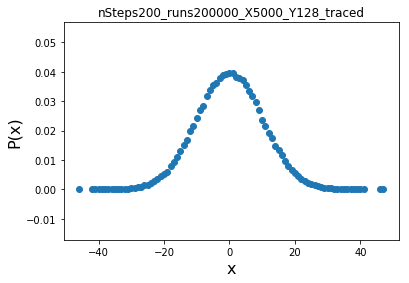

Non-Gaussian Parameter: 0.7913542752106337
Variance: 100.04618394977498
Standard Deviation: 10.002308930930647


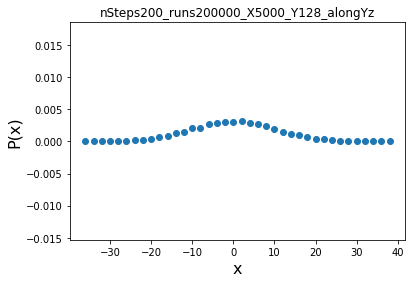

Non-Gaussian Parameter: 0.8005927624785907
Variance: 103.21157797706576
Standard Deviation: 10.159309916380431


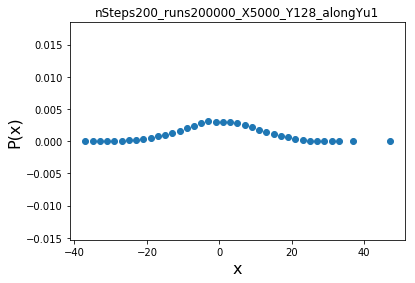

Non-Gaussian Parameter: 0.79188759543824
Variance: 99.84894621711545
Standard Deviation: 9.992444456543927


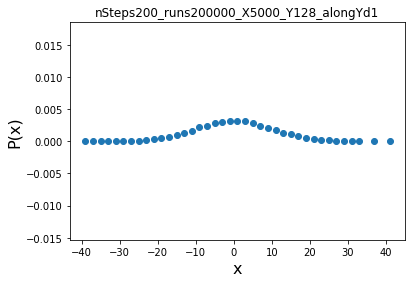

Non-Gaussian Parameter: 0.8312863972433537
Variance: 98.71899702450018
Standard Deviation: 9.935743405729648


In [20]:
calculation(200,200000,5000,128)

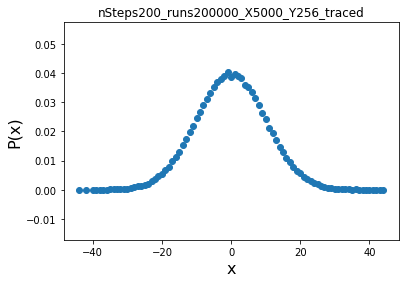

Non-Gaussian Parameter: 0.7838325729543736
Variance: 100.20518551477501
Standard Deviation: 10.010254018493987


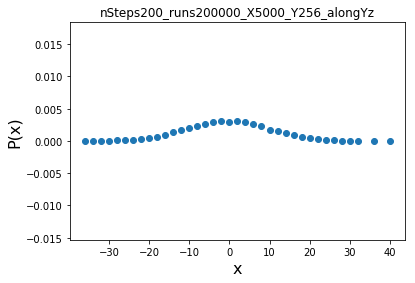

Non-Gaussian Parameter: 0.733419335023052
Variance: 101.76266130722095
Standard Deviation: 10.087748079091833


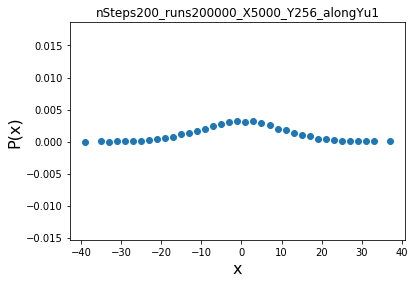

Non-Gaussian Parameter: 0.8441069707717388
Variance: 102.76618486408695
Standard Deviation: 10.137365775391897


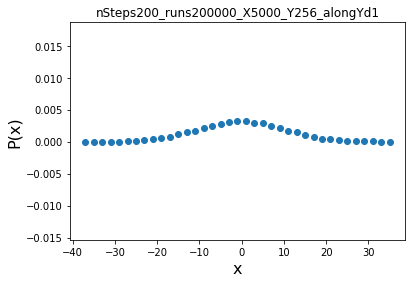

Non-Gaussian Parameter: 0.7602701830693932
Variance: 100.08911933898605
Standard Deviation: 10.004454974609365


In [21]:
calculation(200,200000,5000,256)

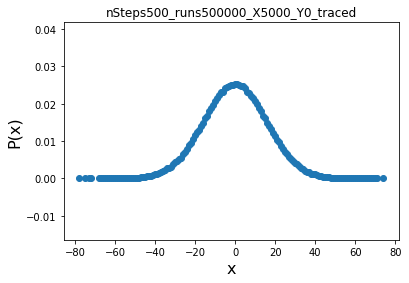

Non-Gaussian Parameter: 0.7976758798762857
Variance: 249.79466529240003
Standard Deviation: 15.80489371341674


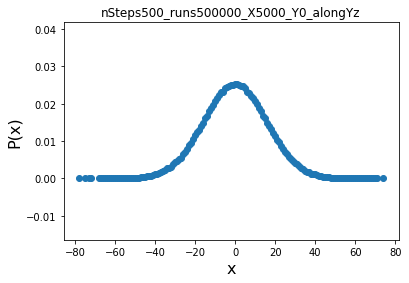

Non-Gaussian Parameter: 0.7976758798762857
Variance: 249.79466529240003
Standard Deviation: 15.80489371341674


In [24]:
calculation(500,500000,5000,0)

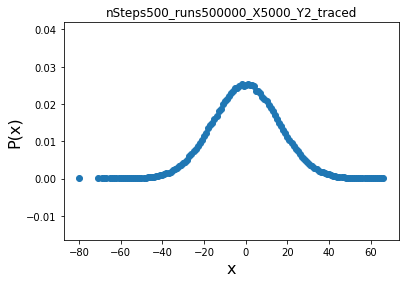

Non-Gaussian Parameter: 0.7956899571058067
Variance: 249.67449155084392
Standard Deviation: 15.801091467074164


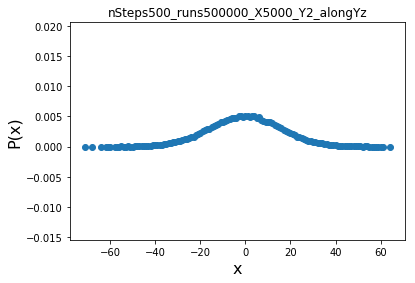

Non-Gaussian Parameter: 0.7956510088829252
Variance: 250.3216924834392
Standard Deviation: 15.821557839967568


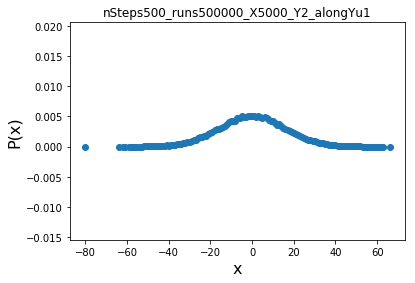

Non-Gaussian Parameter: 0.80374155547982
Variance: 249.38474102627245
Standard Deviation: 15.791920118410948


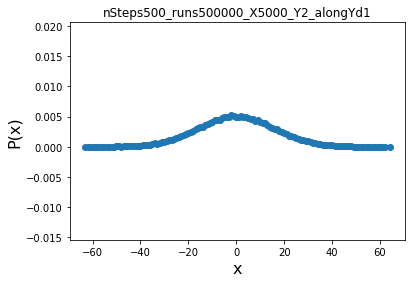

Non-Gaussian Parameter: 0.7916045248664914
Variance: 248.75506497591107
Standard Deviation: 15.771970865301238


In [25]:
calculation(500,500000,5000,2)

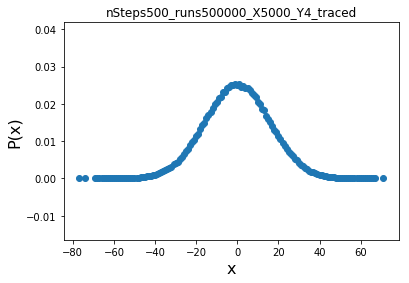

Non-Gaussian Parameter: 0.8016055569127463
Variance: 248.98058583153596
Standard Deviation: 15.779118664600249


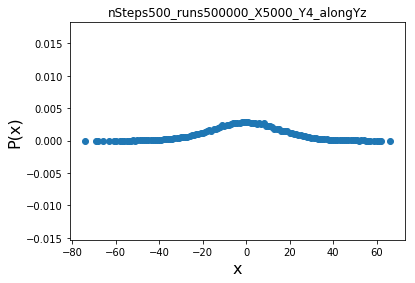

Non-Gaussian Parameter: 0.8195278874149032
Variance: 249.84535945616113
Standard Deviation: 15.80649738101902


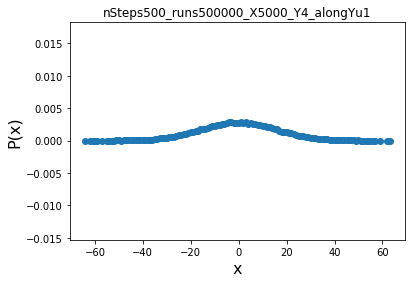

Non-Gaussian Parameter: 0.7728876205345039
Variance: 248.44024427938317
Standard Deviation: 15.761987320112372


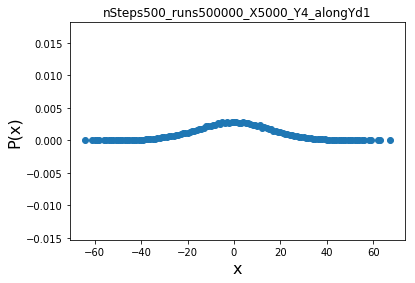

Non-Gaussian Parameter: 0.809434267391139
Variance: 248.78347750223529
Standard Deviation: 15.772871568051116


In [26]:
calculation(500,500000,5000,4)

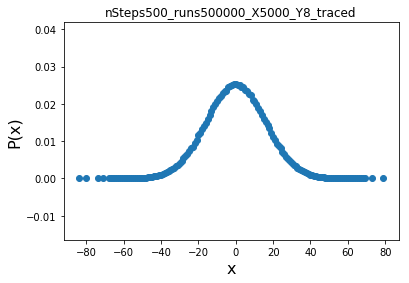

Non-Gaussian Parameter: 0.800086651967608
Variance: 249.84375345391587
Standard Deviation: 15.80644657897264


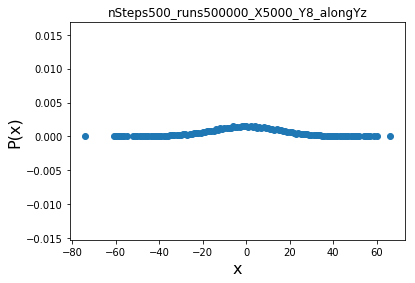

Non-Gaussian Parameter: 0.8107861709674917
Variance: 246.85180746870518
Standard Deviation: 15.711518305647777


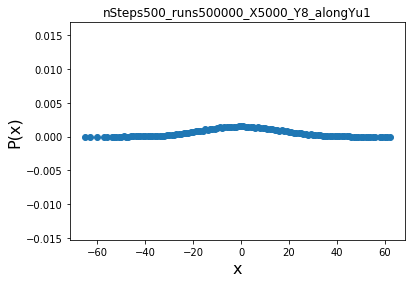

Non-Gaussian Parameter: 0.7653743239924322
Variance: 249.08234388847666
Standard Deviation: 15.78234278833395


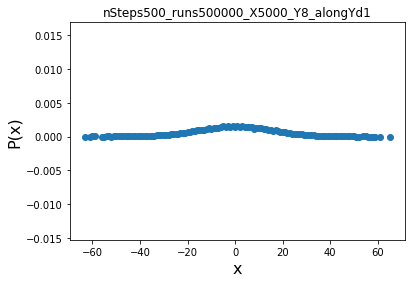

Non-Gaussian Parameter: 0.8258268736115795
Variance: 249.3730867933895
Standard Deviation: 15.791551120564106


In [27]:
calculation(500,500000,5000,8)

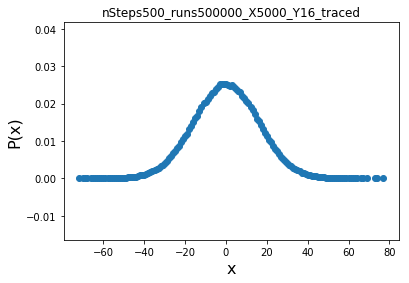

Non-Gaussian Parameter: 0.7986994049465335
Variance: 249.56903441583597
Standard Deviation: 15.797754094042482


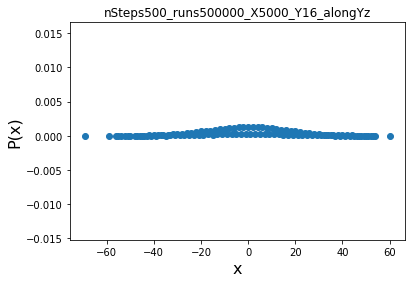

Non-Gaussian Parameter: 0.7885165858199152
Variance: 249.3073543645168
Standard Deviation: 15.789469730314467


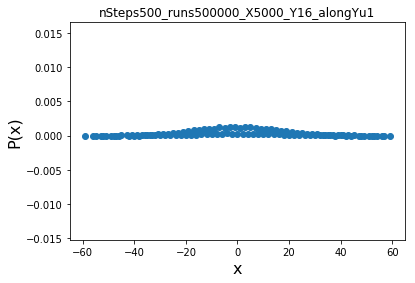

Non-Gaussian Parameter: 0.7925577721725976
Variance: 251.14561207397722
Standard Deviation: 15.847574327763136


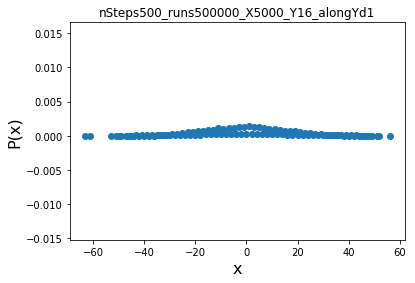

Non-Gaussian Parameter: 0.7400031875604094
Variance: 249.88715400567918
Standard Deviation: 15.80781939439084


In [28]:
calculation(500,500000,5000,16)

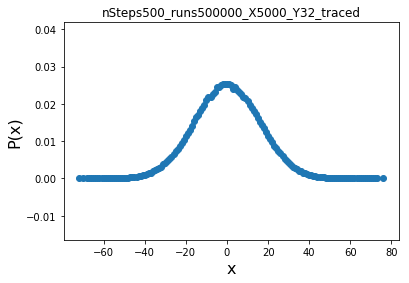

Non-Gaussian Parameter: 0.7964904003713933
Variance: 249.858000655296
Standard Deviation: 15.806897249469802


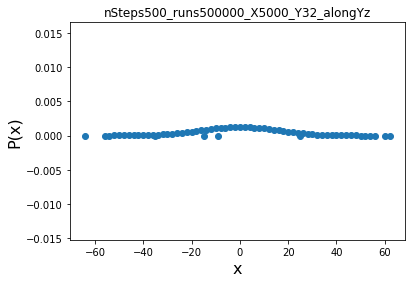

Non-Gaussian Parameter: 0.7724790128470149
Variance: 248.7216099716532
Standard Deviation: 15.770910245501153


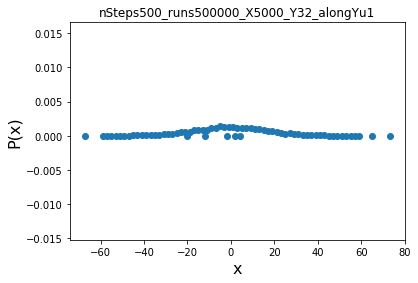

Non-Gaussian Parameter: 0.8408953661979945
Variance: 254.13303827438736
Standard Deviation: 15.941550686002518


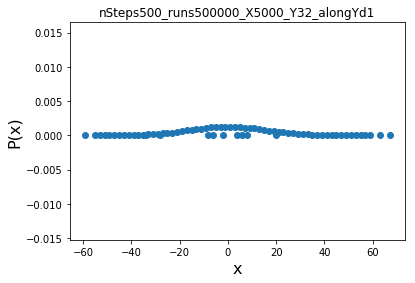

Non-Gaussian Parameter: 0.8207899668147474
Variance: 251.6237080217452
Standard Deviation: 15.862651355361285


In [29]:
calculation(500,500000,5000,32)

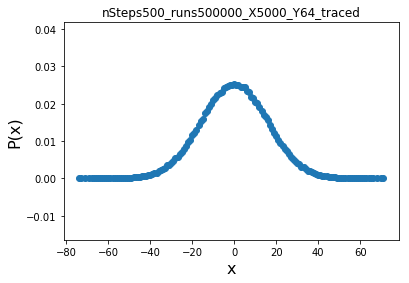

Non-Gaussian Parameter: 0.7987506927111068
Variance: 249.507522707904
Standard Deviation: 15.79580712429422


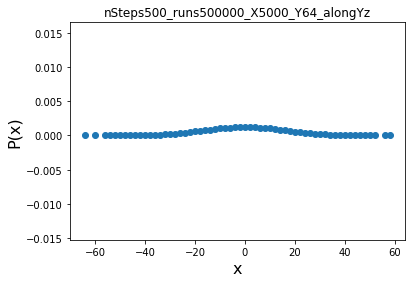

Non-Gaussian Parameter: 0.8016825456395198
Variance: 254.51197746464288
Standard Deviation: 15.953431526309407


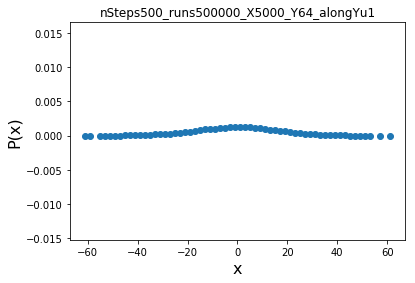

Non-Gaussian Parameter: 0.7642420107862522
Variance: 253.2761270821784
Standard Deviation: 15.914651333980848


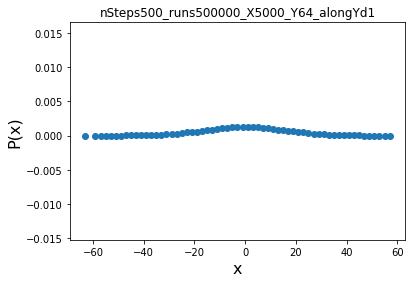

Non-Gaussian Parameter: 0.8149648789351762
Variance: 250.0662834531981
Standard Deviation: 15.813484228758636


In [30]:
calculation(500,500000,5000,64)

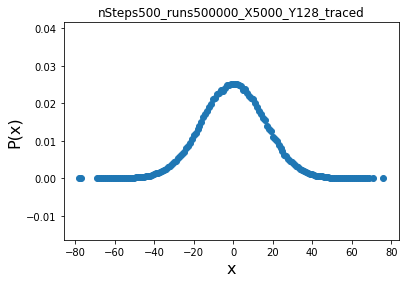

Non-Gaussian Parameter: 0.7981809447431922
Variance: 250.3615310078999
Standard Deviation: 15.82281678488062


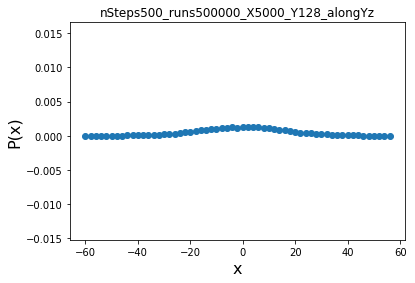

Non-Gaussian Parameter: 0.805337138459848
Variance: 254.658605478791
Standard Deviation: 15.95802636539967


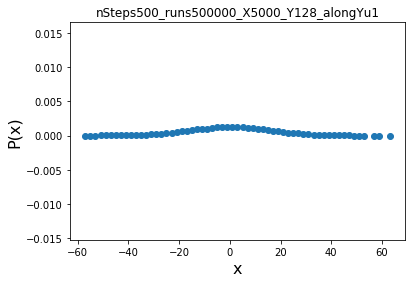

Non-Gaussian Parameter: 0.7986902163474039
Variance: 253.85315936439397
Standard Deviation: 15.932769984042134


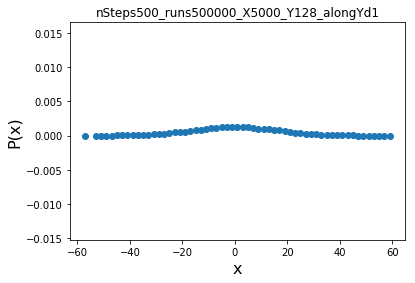

Non-Gaussian Parameter: 0.783647804523774
Variance: 250.12340570866684
Standard Deviation: 15.815290250534982


In [31]:
calculation(500,500000,5000,128)

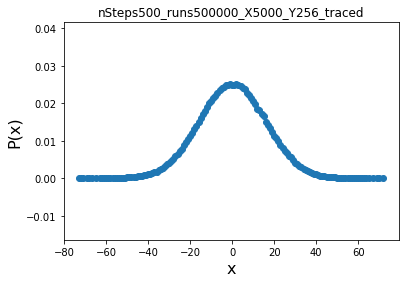

Non-Gaussian Parameter: 0.801909716029483
Variance: 251.032475703004
Standard Deviation: 15.844004408703123


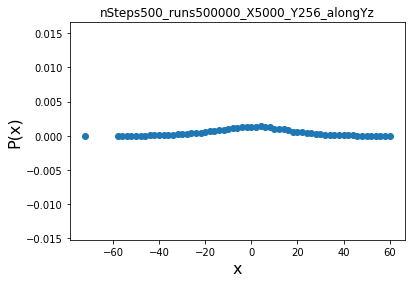

Non-Gaussian Parameter: 0.8338669267249201
Variance: 250.40236287532278
Standard Deviation: 15.824107016679418


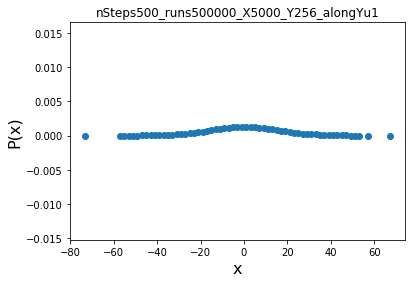

Non-Gaussian Parameter: 0.8296860273394746
Variance: 252.6375408976662
Standard Deviation: 15.894575832580944


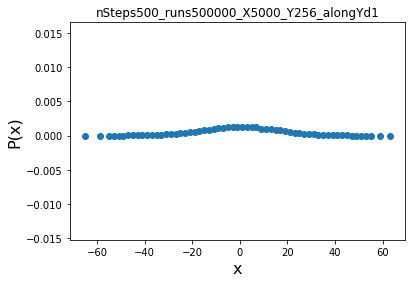

Non-Gaussian Parameter: 0.8309173740796265
Variance: 254.0735106112419
Standard Deviation: 15.939683516658725


In [32]:
calculation(500,500000,5000,256)

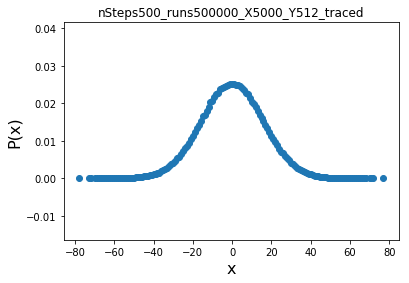

Non-Gaussian Parameter: 0.8038783380727896
Variance: 249.944611381744
Standard Deviation: 15.809636661914277


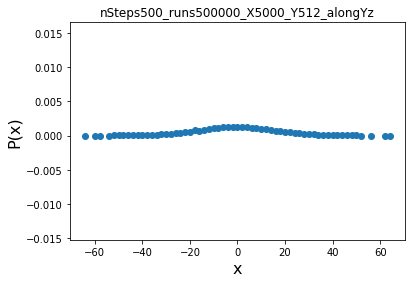

Non-Gaussian Parameter: 0.8304449943464822
Variance: 247.98383040037209
Standard Deviation: 15.747502354353598


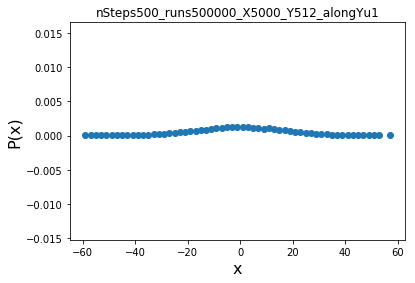

Non-Gaussian Parameter: 0.7492612376552865
Variance: 256.59279974495485
Standard Deviation: 16.018514280199486


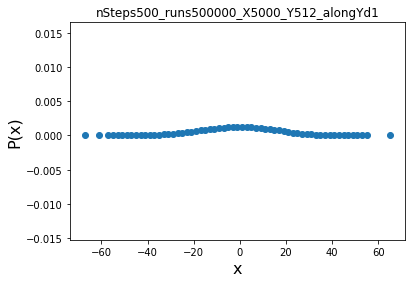

Non-Gaussian Parameter: 0.7765863963294153
Variance: 251.1565833887646
Standard Deviation: 15.847920475215814


In [33]:
calculation(500,500000,5000,512)

In [ ]:
calculation(1000,1000000,5000,0)

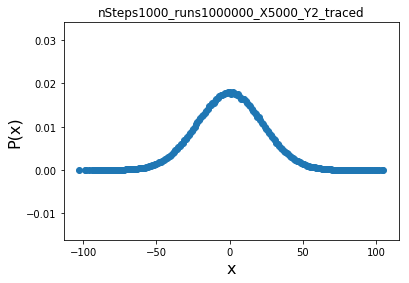

Non-Gaussian Parameter: 0.8050111591300806
Variance: 500.189432261271
Standard Deviation: 22.364915208005396


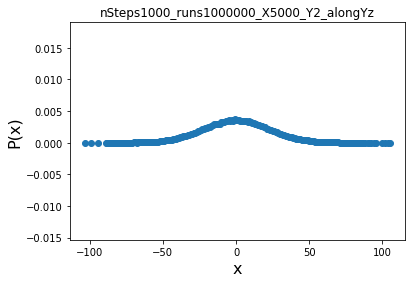

Non-Gaussian Parameter: 0.8110109396638259
Variance: 499.60278685575884
Standard Deviation: 22.351796054361245


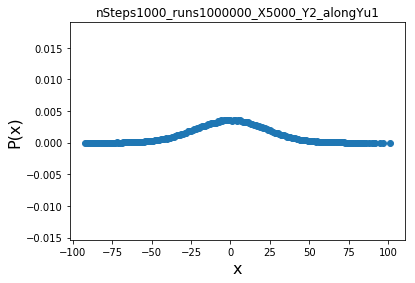

Non-Gaussian Parameter: 0.7907497870453108
Variance: 499.09483072123106
Standard Deviation: 22.340430405908275


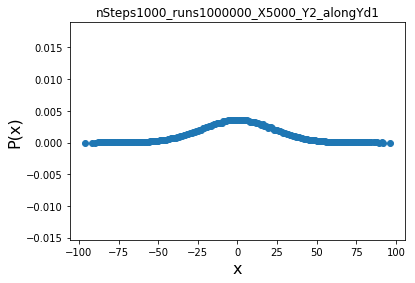

Non-Gaussian Parameter: 0.806944642306713
Variance: 499.09206302364964
Standard Deviation: 22.34036846212814


In [34]:
calculation(1000,1000000,5000,2)

In [ ]:
calculation(1000,1000000,5000,4)

In [ ]:
calculation(1000,1000000,5000,8)

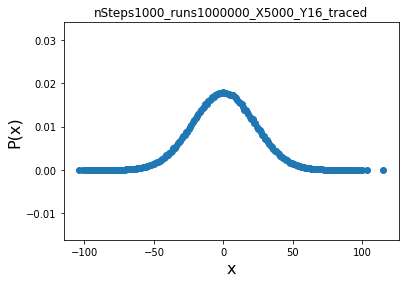

Non-Gaussian Parameter: 0.7987867486441429
Variance: 499.4569673334787
Standard Deviation: 22.348533896734228


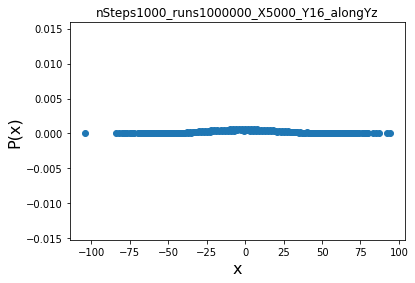

Non-Gaussian Parameter: 0.7905645826692289
Variance: 500.59756078698496
Standard Deviation: 22.3740376505222


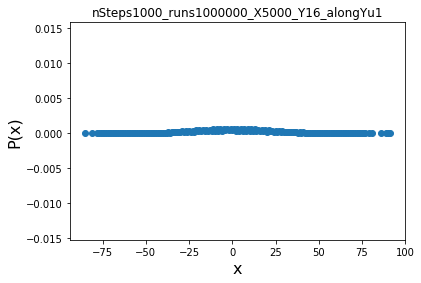

Non-Gaussian Parameter: 0.7787283808323153
Variance: 503.66402969886127
Standard Deviation: 22.442460419901852


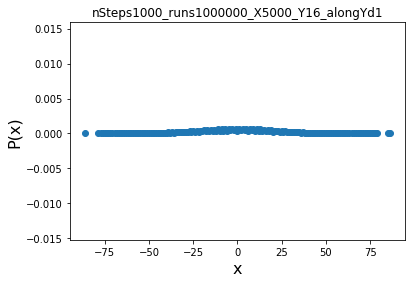

Non-Gaussian Parameter: 0.7921974452342566
Variance: 501.8195704445398
Standard Deviation: 22.401329657958694


In [35]:
calculation(1000,1000000,5000,16)

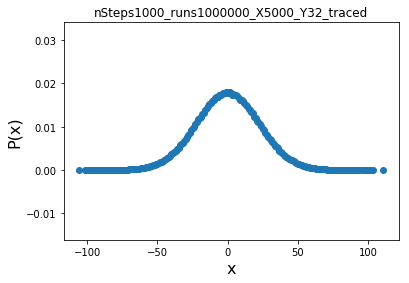

Non-Gaussian Parameter: 0.8011142615726163
Variance: 499.7881171593989
Standard Deviation: 22.35594142860906


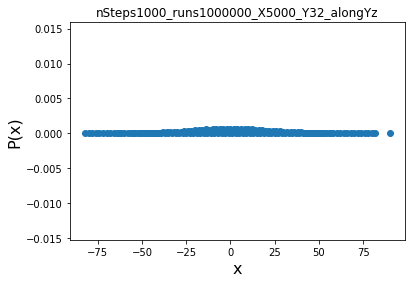

Non-Gaussian Parameter: 0.7756325312594534
Variance: 499.8303005957879
Standard Deviation: 22.35688485893748


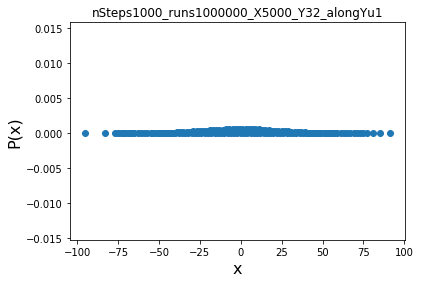

Non-Gaussian Parameter: 0.8159848545925164
Variance: 493.9319464548356
Standard Deviation: 22.224579781288007


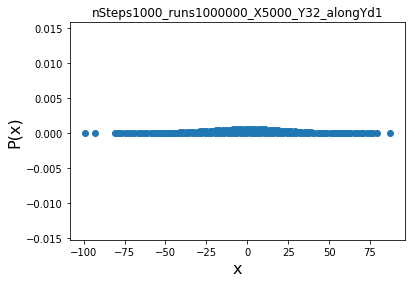

Non-Gaussian Parameter: 0.7993302287675697
Variance: 503.7156707783696
Standard Deviation: 22.44361091220327


In [41]:
calculation(1000,1000000,5000,32)

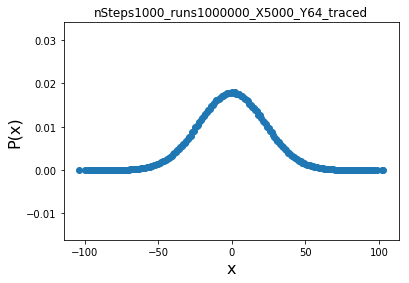

Non-Gaussian Parameter: 0.8010152798338814
Variance: 499.55311865190413
Standard Deviation: 22.350684970530637


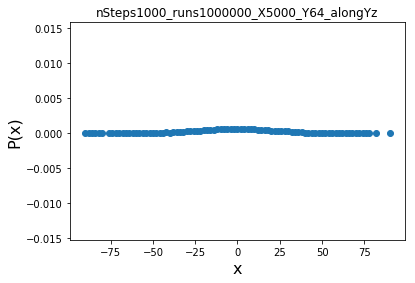

Non-Gaussian Parameter: 0.8192181616122716
Variance: 506.42260639536886
Standard Deviation: 22.50383537078444


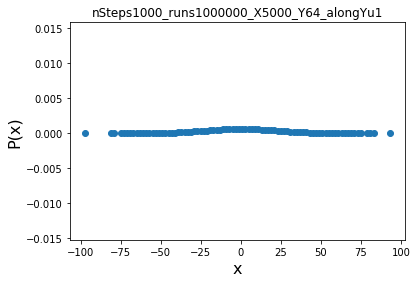

Non-Gaussian Parameter: 0.7591159027093828
Variance: 499.1922776322669
Standard Deviation: 22.342611253662067


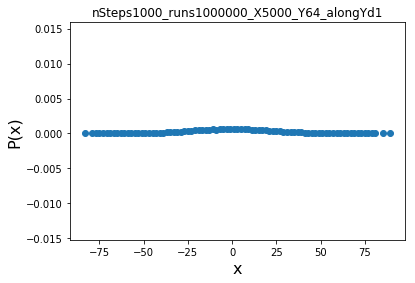

Non-Gaussian Parameter: 0.8220828209738273
Variance: 496.42002392916885
Standard Deviation: 22.280485271402167


In [36]:
calculation(1000,1000000,5000,64)

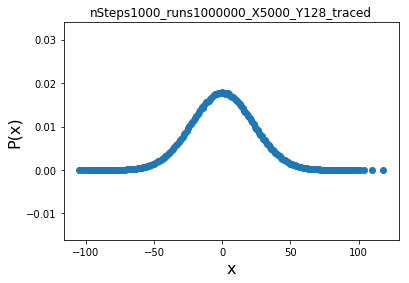

Non-Gaussian Parameter: 0.8011881788713338
Variance: 500.647401752636
Standard Deviation: 22.375151435300634


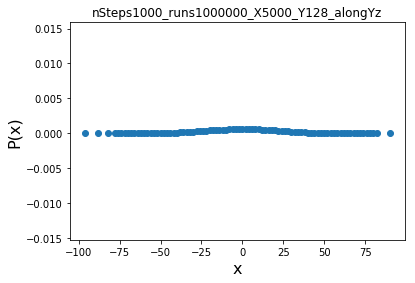

Non-Gaussian Parameter: 0.8371229879032962
Variance: 501.4466758697919
Standard Deviation: 22.393005065640295


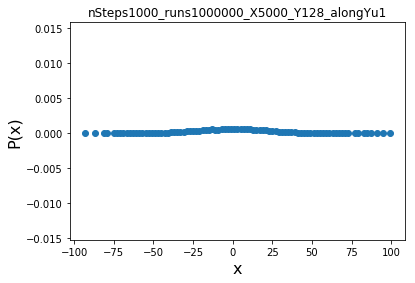

Non-Gaussian Parameter: 0.8516967839533574
Variance: 502.9059111849315
Standard Deviation: 22.425563787448723


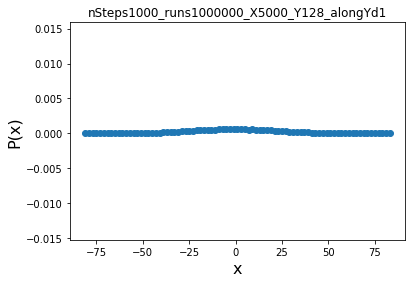

Non-Gaussian Parameter: 0.7773629069320227
Variance: 498.00371117978887
Standard Deviation: 22.315996755237908


In [37]:
calculation(1000,1000000,5000,128)

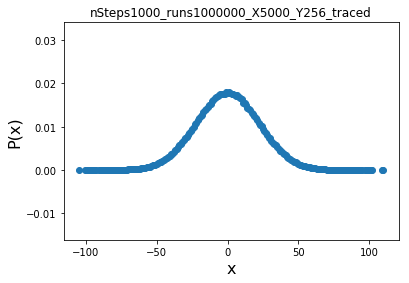

Non-Gaussian Parameter: 0.8002701558465668
Variance: 499.9338087897242
Standard Deviation: 22.3591996455536


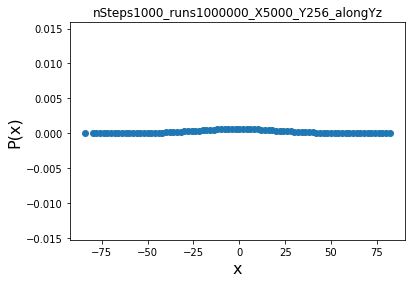

Non-Gaussian Parameter: 0.7701063681732718
Variance: 499.3451862562186
Standard Deviation: 22.346032897501484


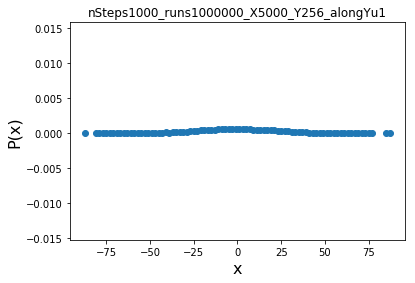

Non-Gaussian Parameter: 0.8153081737261365
Variance: 503.6605389977033
Standard Deviation: 22.44238264974785


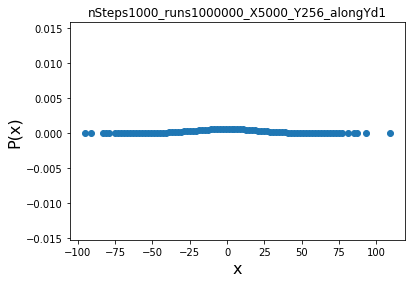

Non-Gaussian Parameter: 0.8347795887219494
Variance: 494.4767970069304
Standard Deviation: 22.236834239768267


In [38]:
calculation(1000,1000000,5000,256)

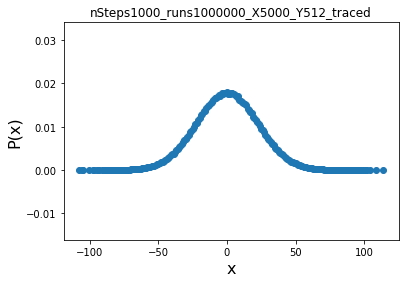

Non-Gaussian Parameter: 0.7977510981072178
Variance: 500.6626741285762
Standard Deviation: 22.37549271253208


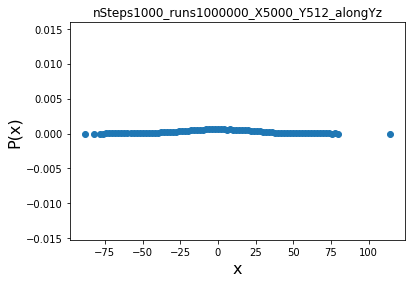

Non-Gaussian Parameter: 0.8101750961406873
Variance: 501.1399068104078
Standard Deviation: 22.386154355101006


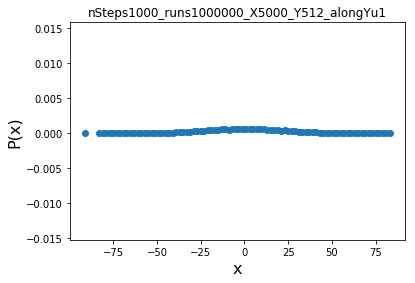

Non-Gaussian Parameter: 0.8069047357941299
Variance: 506.80286174624706
Standard Deviation: 22.51228246416269


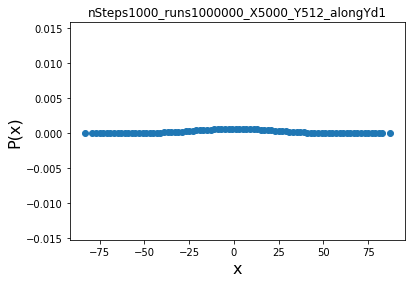

Non-Gaussian Parameter: 0.8212079898355442
Variance: 491.2463692555881
Standard Deviation: 22.1640783533985


In [39]:
calculation(1000,1000000,5000,512)

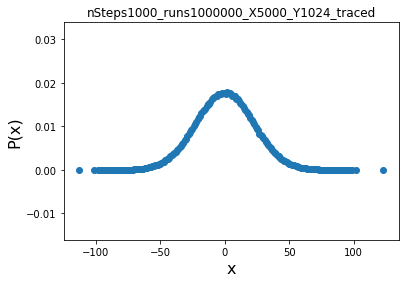

Non-Gaussian Parameter: 0.798177006241688
Variance: 500.6464098871639
Standard Deviation: 22.37512927084811


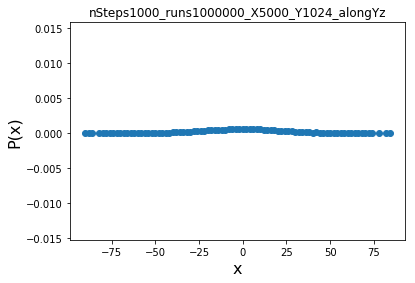

Non-Gaussian Parameter: 0.8147432718395733
Variance: 502.81391882499594
Standard Deviation: 22.423512633505837


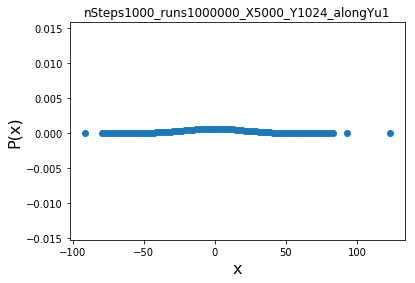

Non-Gaussian Parameter: 0.8356022173258455
Variance: 502.1252680030112
Standard Deviation: 22.40815182033117


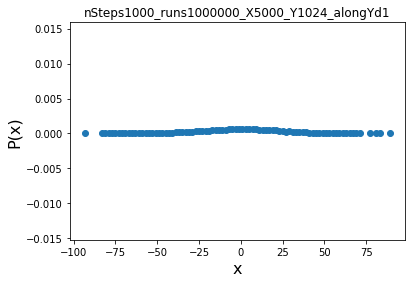

Non-Gaussian Parameter: 0.8216850896172914
Variance: 501.49939866348257
Standard Deviation: 22.394182250385537


In [40]:
calculation(1000,1000000,5000,1024)

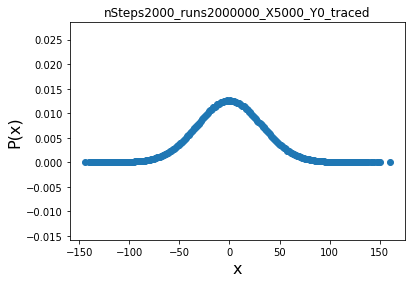

Non-Gaussian Parameter: 0.7970978887663449
Variance: 999.1989319398997
Standard Deviation: 31.610108065932007


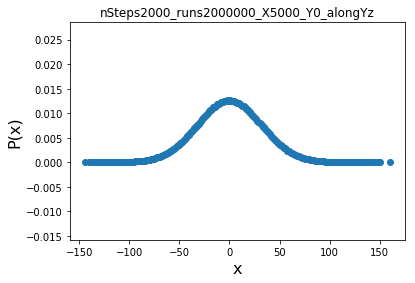

Non-Gaussian Parameter: 0.7970978887663449
Variance: 999.1989319398997
Standard Deviation: 31.610108065932007


In [42]:
calculation(2000,2000000,5000,0)

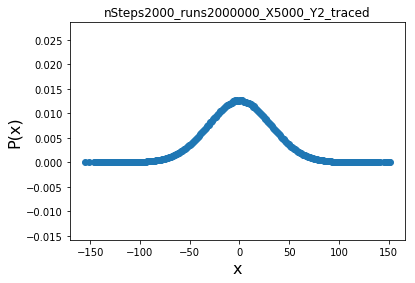

Non-Gaussian Parameter: 0.8050456331102505
Variance: 1000.0144187121768
Standard Deviation: 31.62300458071903


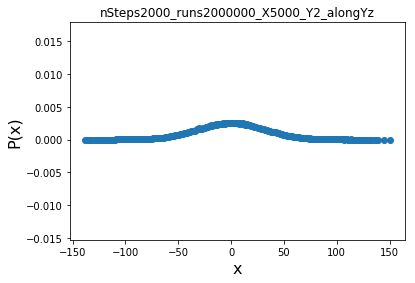

Non-Gaussian Parameter: 0.8027348369363954
Variance: 1001.1161466159967
Standard Deviation: 31.640419507585495


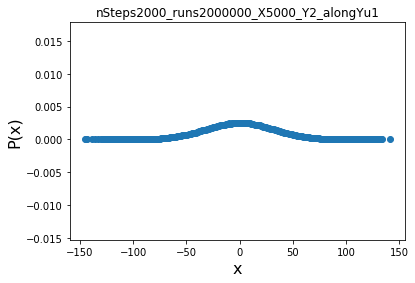

Non-Gaussian Parameter: 0.8051315790237885
Variance: 1003.6166925182968
Standard Deviation: 31.67990991966828


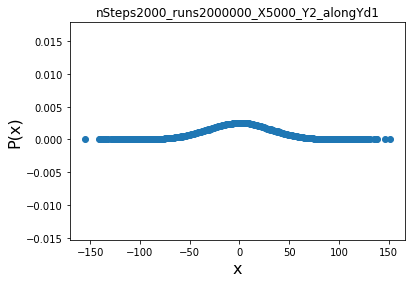

Non-Gaussian Parameter: 0.80752136245545
Variance: 997.5779251689451
Standard Deviation: 31.584457018744917


In [43]:
calculation(2000,2000000,5000,2)

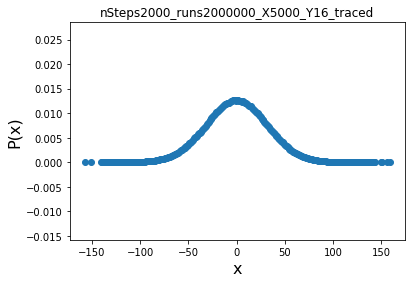

Non-Gaussian Parameter: 0.7998693830009105
Variance: 998.1776492347684
Standard Deviation: 31.593949566883346


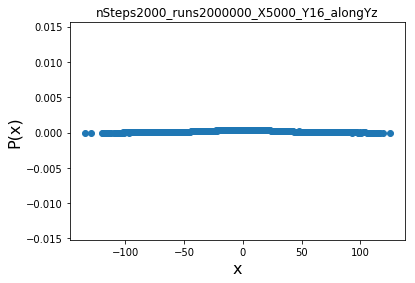

Non-Gaussian Parameter: 0.7953859076326257
Variance: 1004.1374620430146
Standard Deviation: 31.688128093073193


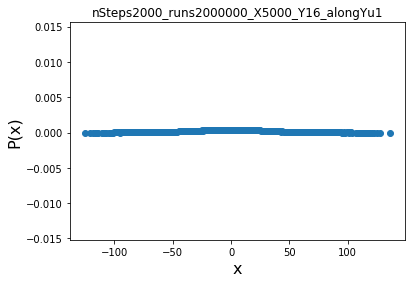

Non-Gaussian Parameter: 0.7993482598099702
Variance: 1007.861913651118
Standard Deviation: 31.746841002706365


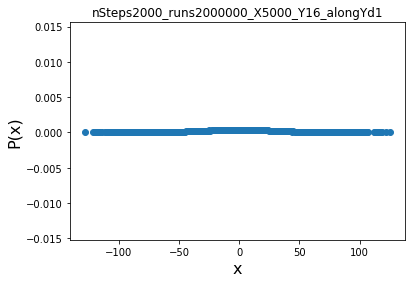

Non-Gaussian Parameter: 0.7974913466488727
Variance: 990.0708569142296
Standard Deviation: 31.46539141523953


In [44]:
calculation(2000,2000000,5000,16)

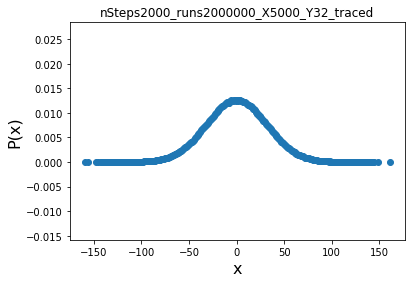

Non-Gaussian Parameter: 0.7998256419699641
Variance: 1001.2459277715774
Standard Deviation: 31.642470317147765


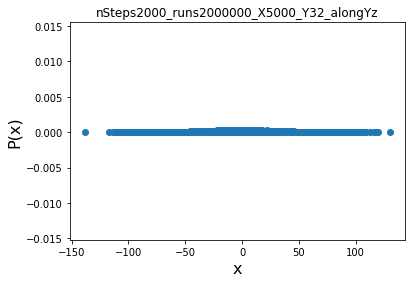

Non-Gaussian Parameter: 0.8053771416285469
Variance: 1000.0812841888077
Standard Deviation: 31.62406179143988


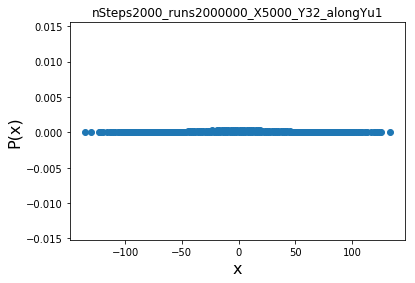

Non-Gaussian Parameter: 0.8211300646134769
Variance: 997.6015396192248
Standard Deviation: 31.58483084677239


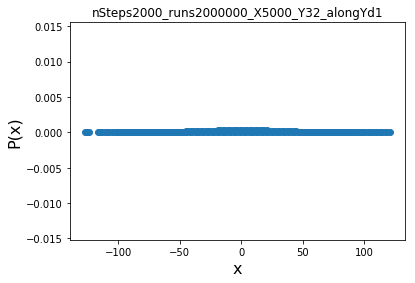

Non-Gaussian Parameter: 0.7983159643965154
Variance: 1006.1901588115732
Standard Deviation: 31.72050060783362


In [45]:
calculation(2000,2000000,5000,32)

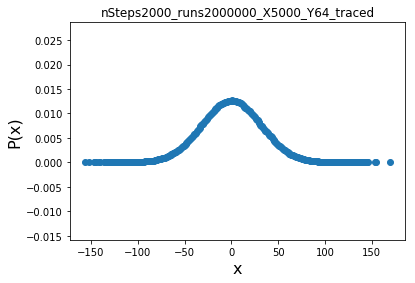

Non-Gaussian Parameter: 0.7995463012493
Variance: 1001.6696281164392
Standard Deviation: 31.64916473015424


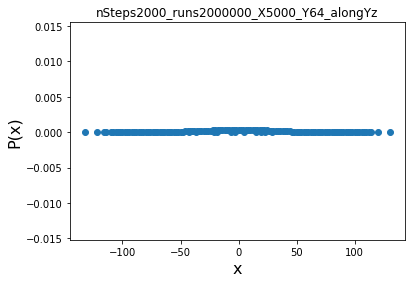

Non-Gaussian Parameter: 0.8053482342892595
Variance: 996.0520544316151
Standard Deviation: 31.560292369235352


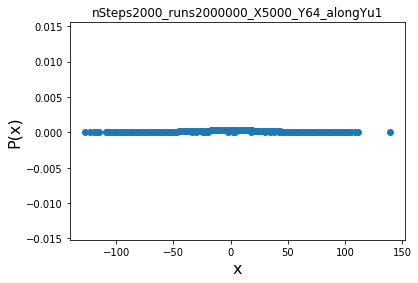

Non-Gaussian Parameter: 0.8048490377983044
Variance: 992.478001250879
Standard Deviation: 31.503618859598955


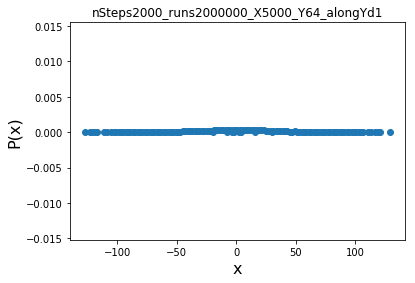

Non-Gaussian Parameter: 0.8026792401720002
Variance: 1007.5777514401793
Standard Deviation: 31.742365246467998


In [46]:
calculation(2000,2000000,5000,64)

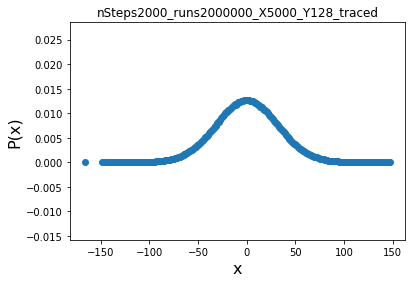

Non-Gaussian Parameter: 0.799017159991998
Variance: 997.9463186181279
Standard Deviation: 31.59028835921141


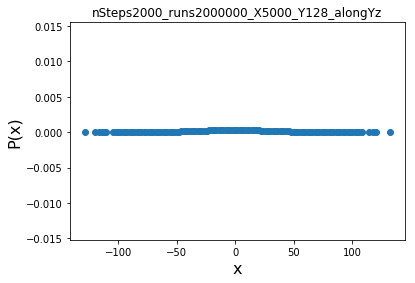

Non-Gaussian Parameter: 0.8082799709122281
Variance: 995.1721425894748
Standard Deviation: 31.54634911664858


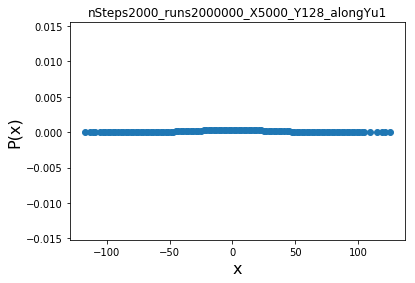

Non-Gaussian Parameter: 0.7829539711948319
Variance: 1000.9456021306183
Standard Deviation: 31.63772435132809


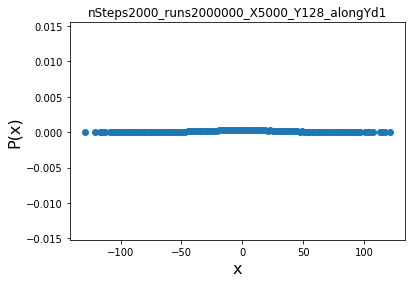

Non-Gaussian Parameter: 0.7937275569360562
Variance: 993.355372668511
Standard Deviation: 31.517540714156475


In [47]:
calculation(2000,2000000,5000,128)

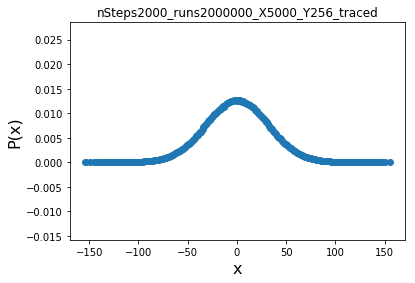

Non-Gaussian Parameter: 0.7957897128225724
Variance: 1000.3846900753239
Standard Deviation: 31.628858500984887


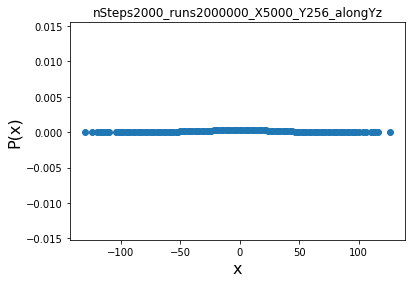

Non-Gaussian Parameter: 0.7818965576057137
Variance: 1005.4558335313749
Standard Deviation: 31.708923563113505


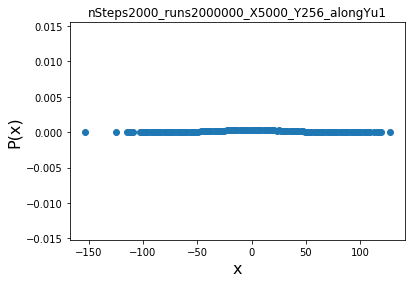

Non-Gaussian Parameter: 0.7934724376764812
Variance: 1007.7019520070043
Standard Deviation: 31.74432157106219


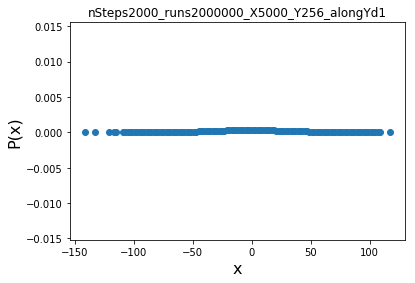

Non-Gaussian Parameter: 0.8032040816443176
Variance: 993.4441710671503
Standard Deviation: 31.518949396627264


In [48]:
calculation(2000,2000000,5000,256)

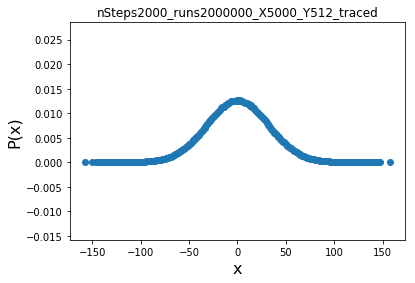

Non-Gaussian Parameter: 0.7985465005827679
Variance: 1000.3030451677001
Standard Deviation: 31.62756780354285


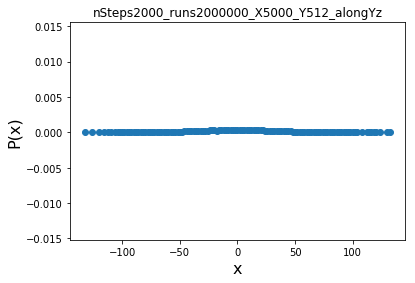

Non-Gaussian Parameter: 0.8256269922435286
Variance: 999.4256300019304
Standard Deviation: 31.613693710193537


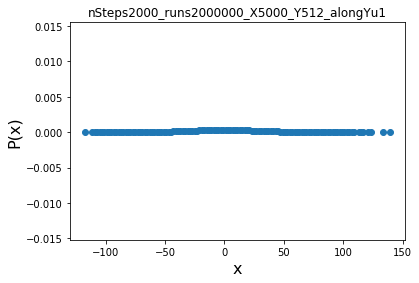

Non-Gaussian Parameter: 0.7979578912427807
Variance: 983.6858752086204
Standard Deviation: 31.363766916756354


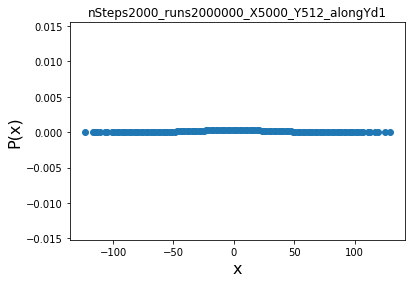

Non-Gaussian Parameter: 0.7858615587121653
Variance: 1011.060381781022
Standard Deviation: 31.797175688746666


In [49]:
calculation(2000,2000000,5000,512)

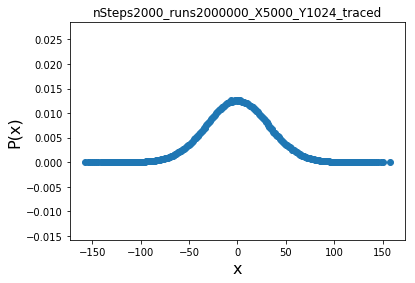

Non-Gaussian Parameter: 0.7996493424323607
Variance: 999.3149072923438
Standard Deviation: 31.611942478948425


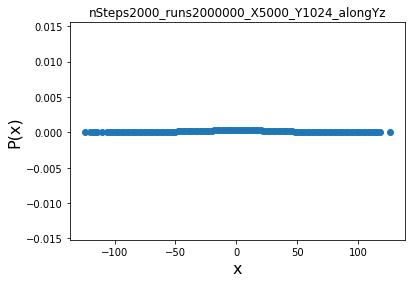

Non-Gaussian Parameter: 0.776070214514075
Variance: 1003.9311023178242
Standard Deviation: 31.684871821072974


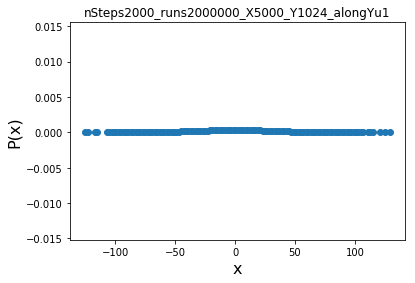

Non-Gaussian Parameter: 0.8206092359421175
Variance: 994.9697675121257
Standard Deviation: 31.54314137038551


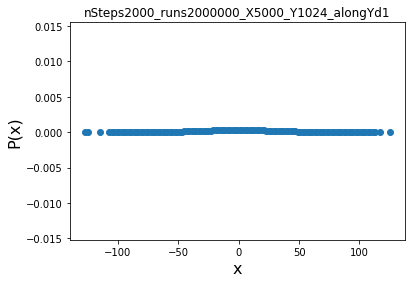

Non-Gaussian Parameter: 0.7834361104795933
Variance: 1006.5396257973276
Standard Deviation: 31.7260086647742


In [50]:
calculation(2000,2000000,5000,1024)

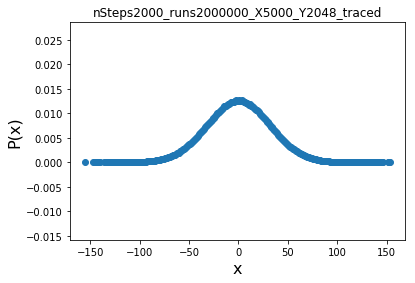

Non-Gaussian Parameter: 0.8016990260021537
Variance: 1000.3230719746795
Standard Deviation: 31.62788440561081


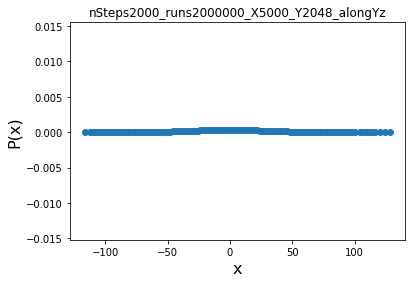

Non-Gaussian Parameter: 0.804888664928316
Variance: 1004.4798952651221
Standard Deviation: 31.693530810957654


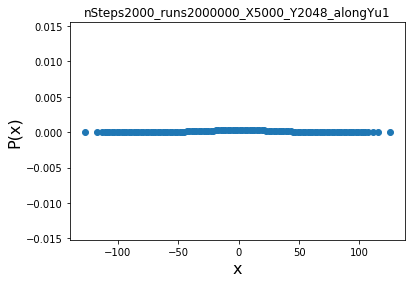

Non-Gaussian Parameter: 0.821345967532598
Variance: 992.2343923704449
Standard Deviation: 31.499752258874114


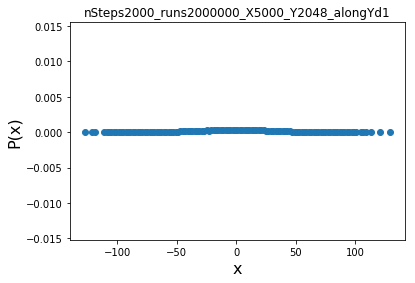

Non-Gaussian Parameter: 0.8001388345073845
Variance: 996.3574660254993
Standard Deviation: 31.56513054028922


In [51]:
calculation(2000,2000000,5000,2048)